# Pine & 8th St. Bioretention Notebook
This file was used for generating figures etc for the manuscript on 6PPD-quinone fate through the Pine and 8th st. bioretention cell


In [15]:
#Load packages

import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set_style('ticks')
import matplotlib.pyplot as plt
#This is the name of the python module containing the Bioretention Blues submodel.
from BioretentionBlues import BCBlues

In [2]:
#Import the res file, load the others
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
#locsumm = pd.read_excel('inputfiles/QuebecSt_TreeTrench.xlsx',index_col = 0)
locsumm = pd.read_excel('inputfiles/Pine8th/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/Pine8th/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/Pine8th/timeseries_wateryear.xlsx')
#chemsumm = pd.read_excel('inputfiles/Kortright_ALL_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/Pine8th/params_Pine8th.xlsx',index_col = 0)
pp = None
#inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/'
inpath = 'C:/Users/trodge01/Documents/BigPickles/'
#res = pd.read_pickle(inpath+'outputspiketest1.pkl')
#res = pd.read_pickle(inpath+'wateryear_fvalve_Foc_Asys_Hp.pkl')
res = pd.read_pickle(inpath+'wateryear_.pkl')
#res = pd.read_pickle(inpath+'20230112_SpikeTestCalibrated.pkl')
#res = pd.read_pickle(fpath+'/pickles/outputtest.pkl')
res.head()

x        dx  time    dm  maskts  maskss  porositywater  \
6PPDQ 240 0  0.012778  0.025556   0.0  True   False    True           0.42   
          1  0.038333  0.025556   0.0  True   False    True           0.42   
          2  0.063889  0.025556   0.0  True   False    True           0.42   
          3  0.089444  0.025556   0.0  True   False    True           0.42   
          4  0.115000  0.025556   0.0  True   False    True           0.42   

               Awater  Vsubsoil        V2  ...  M6_t1  a7_t1  M7_t1  a8_t1  \
6PPDQ 240 0  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   
          1  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   
          2  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   
          3  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   
          4  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   

             M8_t1  Mqin  Min_p  Mover_p  M_xf  M_n  
6PPDQ 240 0    0.0   0.0    0.0      NaN   0.0  0.0  
          1    0.0   NaN    NaN      NaN   0.0  0.0  
          2    0.0   NaN    NaN      NaN   0.0  0.0  
          3    0.0   NaN    NaN      NaN   0.0  0.0  
          4    0.0   NaN    NaN      NaN   0.0  0.0  

[5 rows x 474 columns]

In [5]:
#Calculate the masses
#timeseries = pd.read_excel('inputfiles/2014_timeseries.xlsx')
bc = BCBlues(locsumm,chemsumm,params,timeseries,numc)
#timeseries = timeseries.loc[timeseries.time<240,:]
indfactor = 1#3#3#'Load' #3#3
if indfactor == 'Load':
    timeseries = pd.read_pickle(pklpath+timedfname)
else:
    try: 
        int(indfactor) == indfactor
        timeseries = bc.modify_timestep(timeseries,indfactor)
    except TypeError:
        pass
#timeseries = timeseries[timeseries.time<=6]
bc = BCBlues(locsumm,chemsumm,params,timeseries,numc)
mbal = bc.mass_balance(res,numc)
mbal_cum = bc.mass_balance_cumulative(numc, mass_balance = mbal,normalized=True)
mbal_cum.head()
mass_flux = bc.mass_flux(res,numc) 

In [7]:
#Calculate the MEC
#mass_flux = bc.mass_flux(res,numc) 
numx = len(res.index.levels[2])-1
Q_stormsewer = np.array(res.loc[(slice(None),slice(None),numx-1),'Qout'])\
    + np.array(res.loc[(slice(None),slice(None),numx),'advpond'])
pct_Qover = np.array(res.loc[(slice(None),slice(None),numx),'advpond'].sum())\
                                      /np.array(res.loc[(slice(None),slice(None),numx),'Qin'].sum())
#Mean Effluent Concentration (ng/L)
#res.loc[:,'MEC_ngl'] = 1e6*((mass_flux.loc[:,['N_effluent','Nadvpond']].sum(axis=1).groupby(level=[0,1]).sum())\
#                                /np.array(Q_stormsewer)).groupby(level=0).mean()*chemsumm.loc[:,'MolMass']
MEC = 1e6*((mass_flux.loc[:,['N_effluent','Nadvpond']].sum(axis=1).groupby(level=[0]).sum())\
                                    /np.array(Q_stormsewer.sum()))*chemsumm.loc[:,'MolMass']
MEC

6PPDQ        154.056277
Bromide       64.553226
Rhodamine    477.784620
dtype: float64

In [ ]:
#Plot the hydrology
hydro_name = 'flowtest.pkl'
flow_time = pd.read_pickle(inpath + hydro_name)
Qmeas = timeseries.loc[timeseries.time>=0,['time','Qout_meas']]
ylabel = 'Flow Rate (m³/h)'
xlabel = 'Time'
fig,ax = plt.subplots(1,2,figsize=(14,8),dpi=300,sharey=True)
#First event
comp = 'drain'
mask1 = (flow_time.time>=0) & (flow_time.time<6)
ax[0].plot(flow_time.loc[(mask1.copy(),comp),'time'],flow_time.loc[(mask1.copy(),comp),'Q_todrain'])
#startind = len(Qmeas)- len(flow_time.loc[(mask1,'drain'),'time'])
ax[0].plot(flow_time.loc[(mask1,'drain'),'time'],Qmeas.loc[Qmeas.time<6,'Qout_meas'],'k') 
ax[0].plot(flow_time.loc[(mask1.copy(),comp),'time'],flow_time.loc[(mask1.copy(),'pond'),'Q_in'],'#808080')
#Second Event
comp = 'drain'
mask2 = (flow_time.time>=143)
ax[1].plot(flow_time.loc[(mask2.copy(),comp),'time'],flow_time.loc[(mask2.copy(),comp),'Q_todrain'])
#startind = len(Qmeas)- len(flow_time.loc[(mask1,'drain'),'time'])
ax[1].plot(flow_time.loc[(mask2,'drain'),'time'],Qmeas.loc[Qmeas.time>=143,'Qout_meas'],'k') 
ax[1].plot(flow_time.loc[(mask2.copy(),comp),'time'],flow_time.loc[(mask2.copy(),'pond'),'Q_in'],'#808080')
ax[0].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel)
ax[0].set_ylim([0,10])
fpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
#fig.savefig(fpath+'HydroFig.pdf', format='pdf',bbox_inches= 'tight')   

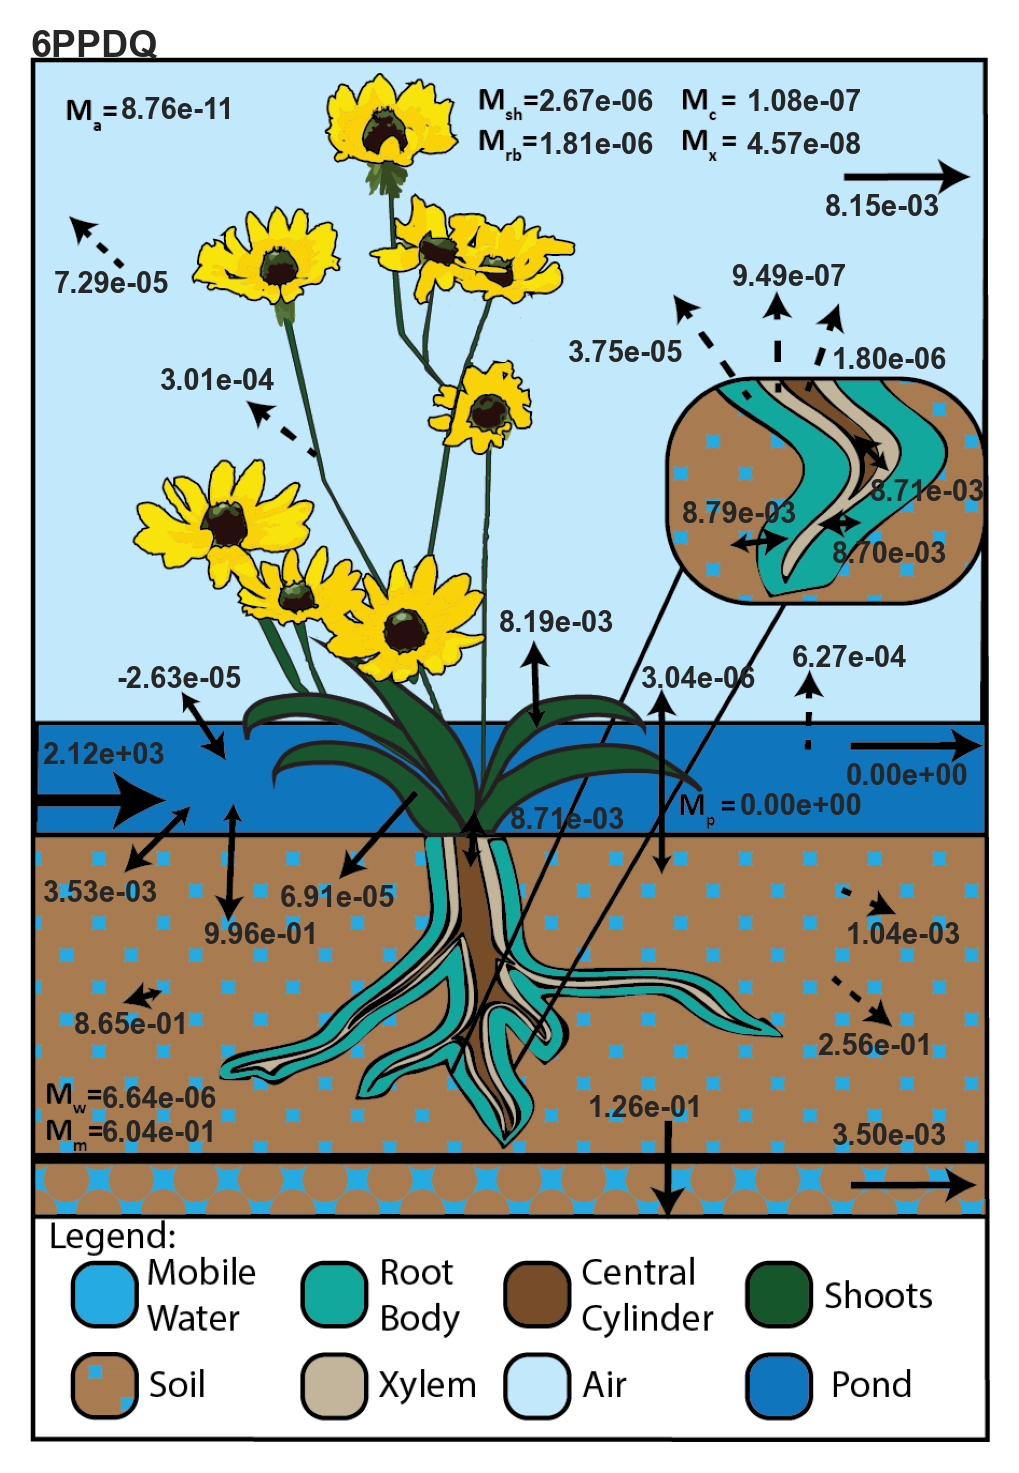

In [6]:
#Plot the fate diagram. Choose the compound and the time to display (in hours).
compound = '6PPDQ'#'Bromide'#use same name as in chemsumm
#Set time (hrs), any time after end gives the end.
time = 10000#6#1000#6#1000
fig,ax = bc.BC_fig(numc,mass_balance=mbal_cum,time = time,compound=compound,figheight=6,fontsize=7,dpi=300)
#Save the figure if you like. I save in pdf then edit in illustrator.
fpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
#fig.savefig(fpath+'OutputModelFig_wateryear_fvalve_Foc_Kinf_Hp.pdf', format='pdf',bbox_inches= 'tight')  
fig.savefig(fpath+'OutputModelFig_basewateryear.pdf', format='pdf',bbox_inches= 'tight')  

In [14]:
Couts = bc.conc_out(numc,timeseries,chemsumm,res)
Couts.loc[:,'6PPDQ_Coutest'] = Couts.loc[:,'6PPDQ_Coutest'] *1e6 #ng/L
Couts.head()
measdat = pd.read_excel('Tracer_test_measurements.xlsx')
Couts.head()

time  Qout_meas  Qout  6PPDQ_Coutmeas  6PPDQ_Coutest  \
244  0.000000        0.0   0.0             0.0            0.0   
245  0.005556        0.0   0.0             0.0            0.0   
246  0.011111        0.0   0.0             0.0            0.0   
247  0.016667        0.0   0.0             0.0            0.0   
248  0.022222        0.0   0.0             0.0            0.0   

     Bromide_Coutmeas  Bromide_Coutest  Rhodamine_Coutmeas  Rhodamine_Coutest  
244               0.0              0.0                 0.0                0.0  
245               0.0              0.0                 0.0                0.0  
246               0.0              0.0                 0.0                0.0  
247               0.0              0.0                 0.0                0.0  
248               0.0              0.0                 0.0                0.0

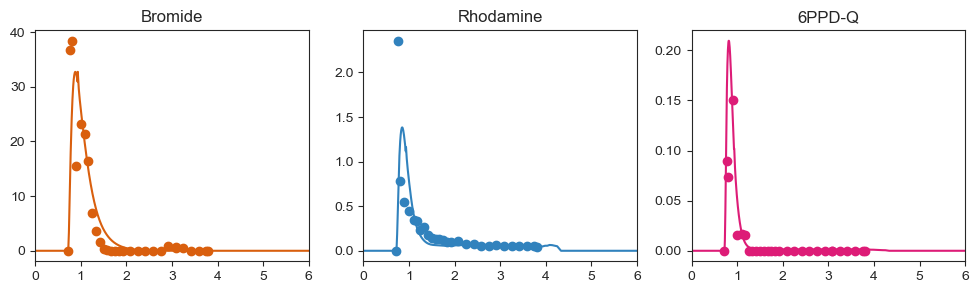

In [20]:
#Model Performance Plots
measdat = pd.read_excel('Tracer_test_measurements.xlsx')
fig,axs = plt.subplots(1,3,figsize=(12,3),sharex='all')
#Plot 1 - Bromide, Benzotriazole, Rhodamine (mg/L)
axs[0].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['Bromide_meas (mg/L)']],color='#d95f0e') #fec44f #d95f0e
#axs[0,0].scatter(measdat.loc[:,'Time(hrs)']
#                            ,measdat.loc[:,['Benzotriazole_meas(mg/L)']],color='#756bb1') #bcbddc, #756bb1
axs[1].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['Rhodamine_meas (mg/L)']],color='#3182bd')#9ecae1, #3182bd
#Line Plots
axs[0].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['Bromide_Coutest']],color='#d95f0e')#fec44f #d95f0e
#axs[0,0].plot(Couts.loc[:,'time']
#                            ,Couts.loc[:,['Benzotriazole_Coutest']],color='#756bb1')#bcbddc, #756bb1
axs[1].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['Rhodamine_Coutest']],color='#3182bd')#9ecae1, #3182bd
#Plot 2 - 6PPDQ (ng/L)
axs[2].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['6PPDQ_meas (ng/L)']],color='#dd1c77') #dd1c77 #c994c7
#Line Plots
axs[2].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['6PPDQ_Coutest']],color='#dd1c77')#dd1c77 #c994c7
axs[0].set_xlim((0,6))
axs[0].set_title('Bromide')
axs[1].set_title('Rhodamine')
axs[2].set_title('6PPD-Q')
#axs[0,0].set(xlim=(0, 7.2))
#axs[0,0].set(ylim=(0, 95))
#axs[0,1].set(ylim=(0, 395))
#axs[1,0].set(ylim=(0, 9.5))
fpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
fig.savefig(fpath+'testvsest_20230112.pdf', format='pdf',bbox_inches= 'tight')  

In [16]:
from hydroeval import kge #Kling-Gupta efficiency (Kling-Gupta et al., 2009)
import hydroeval
Couts2 = bc.conc_out(numc,timeseries,chemsumm,res)
KGE = {}
for ind,chem in enumerate(chemsumm.index):
    try:
        KGE[chem] = (hydroeval.evaluator(kge, np.array(Couts2.loc[:,chem+'_Coutest']),\
                          np.array(Couts2.loc[:,chem+'_Coutmeas'])))
    except KeyError:
        pass
KGE

{'6PPDQ': array([[0.11111702],
        [0.92683556],
        [1.48656729],
        [1.74027845]]),
 'Bromide': array([[0.83557735],
        [0.90648603],
        [1.03120514],
        [1.13159098]]),
 'Rhodamine': array([[0.71261024],
        [0.74228317],
        [1.12098759],
        [1.03920348]])}

In [ ]:
mass_flux = bc.mass_flux(res,numc)
recovery = mass_flux.N_effluent.groupby(level=0).sum()/mass_flux.N_influent.groupby(level=0).sum()
recovery

In [207]:
#full_series = pd.read_excel('inputfiles/wateryear_timeseries.xlsx')
#SWMMseries.head()
timeseries = pd.DataFrame(columns = ['dt','elapsedtime','precip','runoff'])
ind = 0
#pdb.set_trace()
timeseries.loc[ind,:] = 0.
SWMMseries = full_series#[:5000]
p_shift = 10*60 #Start changing timestep X hrs before precipitation
r_shift = 1*60 #Start changing timestep X hrs after Qin ends
SWMMseries.loc[:,'p_shift'] = SWMMseries.Precip.shift(-15*60)#Start changing X hrs before precipitation
#Chose 15 hrs to give 6,3,2,1,0.5,0.5,0.25,0.25,0.25,0.25,10/60,10/60,10/60,10/60,5/60,5/60,5/60,5/60,1/60
#SWMMseries.loc[:,'r_shift'] = SWMMseries.Runoff.shift(-1*60)#Start changing X hrs after Qin ends
pswitch = False #To ramp up
rswitch = True #To ramp down. Start true.
ramp = np.array([6.0,3.0,2.0,1.0,0.5,0.25,10/60,5/60,1/60])
rampstep = 3
dt = 3.0 #Hours. Baseline is 6 hours in dry periods, 1 minute in wet periods
t = 0
while t < len(SWMMseries.index):
    #pdb.set_trace()
    if pswitch == True: #Ramp timestep down to 1 minute and stay there until rswitch activates
        rampstep = rampstep + 1
        if rampstep >= len(ramp):#stay at 1/60 if there
            rampstep = len(ramp)-1       
        #Start to ramp up to 6 hrs if the next X minutes all have zero flow & Y mins have 0 precipitation 
        if  (rswitch == False) & (SWMMseries.loc[t:t+r_shift,'Runoff'].sum() == 0)& (SWMMseries.loc[t:t+p_shift,'Precip'].sum() == 0):
            rswitch = True
            pswitch = False
            
    elif rswitch == True:
        rampstep = rampstep - 1
        if rampstep < 0:#stay at 6 hrs if there
            rampstep = 0 
        #Start to ramp down to 1 minute when precipitation appears
        if (pswitch == False) & (SWMMseries.loc[t:t+p_shift,'Precip'].sum() != 0):
            pswitch = True
            rswitch = False
            #rampstep = 0
    #Now, we are going to make the timeseries for the BC Blues model 
    #Each timestep represents the average from t to t + dt (not including the last step)
    #Elapsed time at the beginning of the timestep (hrs)
    #timeseries.loc[ind,'elapsedtime'] += dt
    #Then, change dt
    dt = ramp[rampstep]
    timeseries.loc[ind+1,'elapsedtime'] = timeseries.loc[ind,'elapsedtime']+dt
    #Next, add the accumulated precipitation and runoff across the timestep
    SWMMend = int(dt *60)-1 #Averaging period
    timeseries.loc[ind,'dt'] = dt
    timeseries.loc[ind,'precip'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Precip'])*1/60/dt #mm/hr
    timeseries.loc[ind,'runoff'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Runoff'])*1/60/dt*3.6 #m³/h
    while (dt > ramp[-1]) & (timeseries.loc[ind,'runoff'] > 0):
        rampstep = rampstep +1
        dt = ramp[rampstep]
        timeseries.loc[ind+1,'elapsedtime'] = timeseries.loc[ind,'elapsedtime']+dt
        #Next, add the accumulated precipitation and runoff across the timestep
        SWMMend = int(dt *60)-1 #Averaging period
        timeseries.loc[ind,'dt'] = dt
        timeseries.loc[ind,'precip'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Precip'])*1/60/dt #mm/hr
        timeseries.loc[ind,'runoff'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Runoff'])*1/60/dt*3.6 #m³/h    
    #To finish, we will go to the next t based on dt
    t += int(dt*60)
    ind += 1
    #Ramp up to 1 minute from 6 hours when pswitch triggers
#timeseries.loc[0,'dt'] = 6
timeseries = timeseries.drop(index=max(timeseries.index))
#timeseries[:25]
#timeseries.to_excel('inputfiles/swmmouts_2014.xlsx')
timeseries.to_excel('inputfiles/swmmouts_wateryear.xlsx')

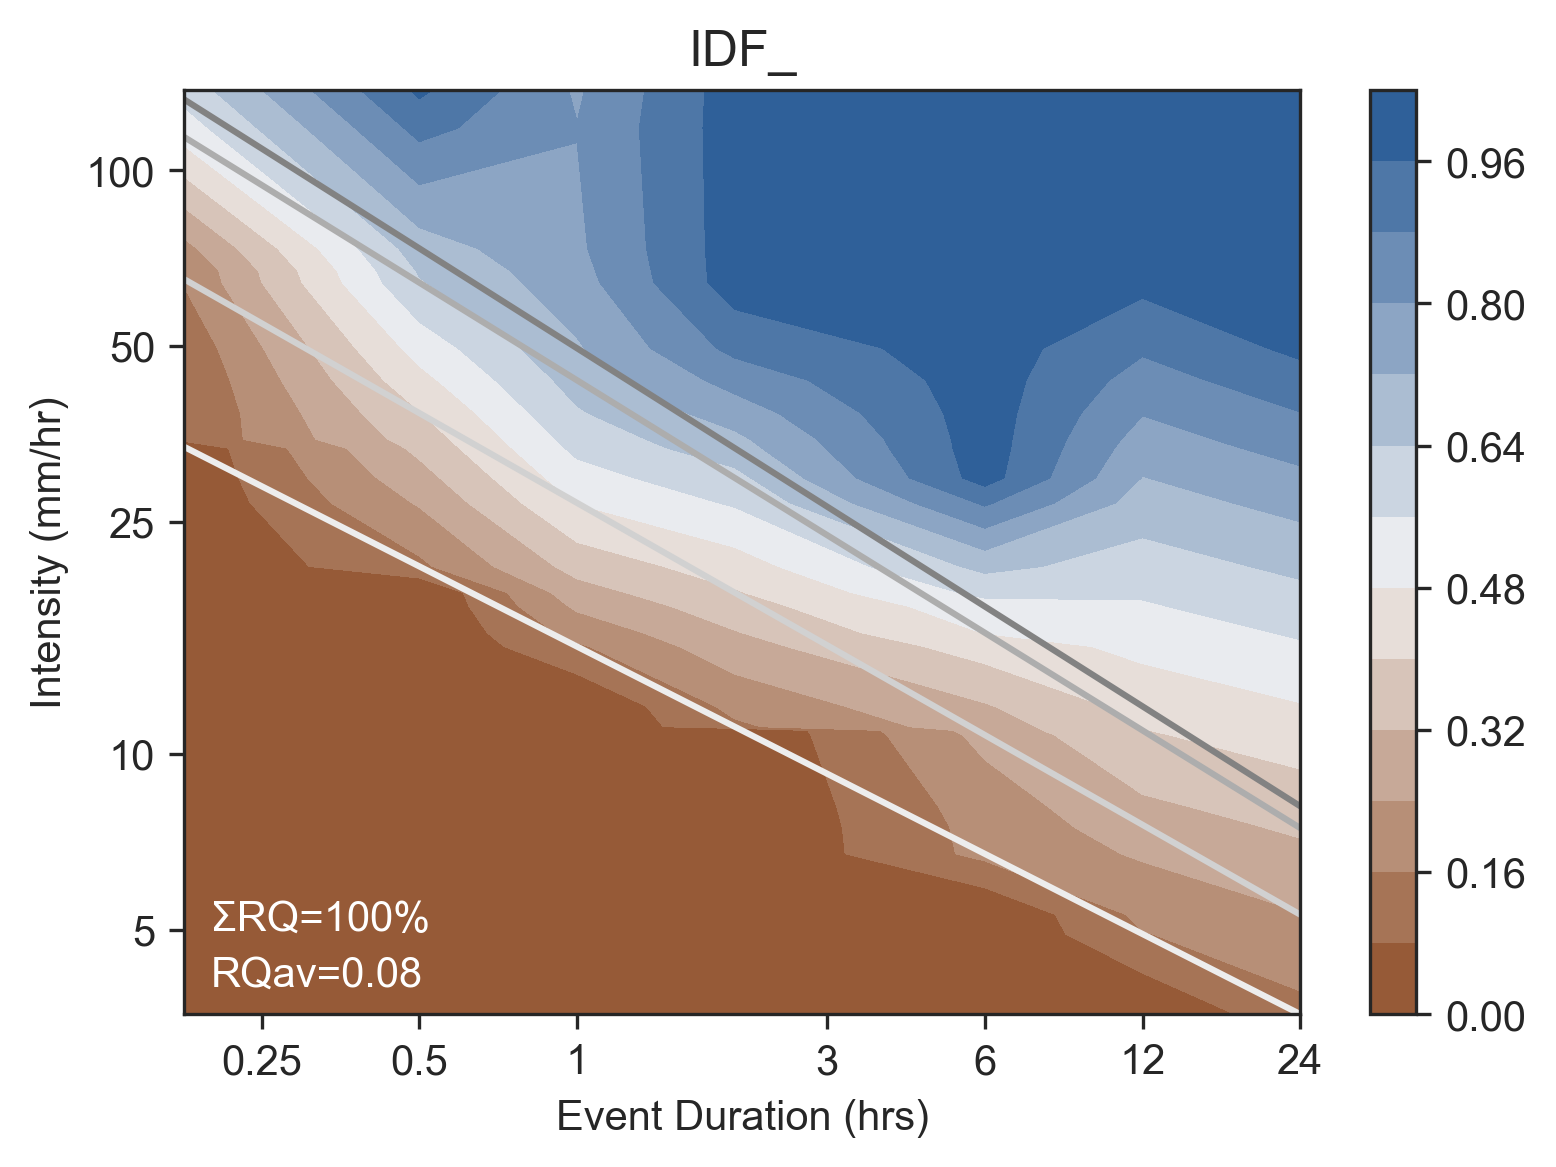

In [4]:
#Plot system performance on IDF curves. This plots the actual values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/Pine8th/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/Pine8th/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/Pine8th/timeseries_IDFstorms.xlsx')
#Load data
#defname = ['IDF_defaults.pkl']
#defname = 'IDF_.pkl'
defname = 'IDF_lowKn.pkl'
defdata = pd.read_pickle(inpath+defname)
defdata = defdata.loc['6PPDQ',:]
#scenarios = ['defaults','fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False}
combos = ((0,0,0,0,0,0,0,0),)#,(0,0,0,1,0,0),(1,1,0,0,1,0),(1,1,0,0,0,0),(0,1,0,1,0,0))
#combos = list(itertools.product([0,1],repeat=6))
#for scenario in scenarios:
for combo in combos:
    #pdb.set_trace()
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    #Change this to match the actual name
    testname = 'IDF_lowkn'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    pltdata = pd.read_pickle(inpath+testname)
    pltdata = pltdata.loc['6PPDQ',:]
    #Define the x and y axes
    xticks = [0.25,0.5,1,3, 6,12,24]
    xticks = [np.log10(xticks),xticks]
    yticks = [5,10,25,50,100]
    yticks = [np.log10(yticks),yticks]
    #Define the variables to plot
    pltvars=['pct_stormsewer','LogD','LogI']
    #pltvars=['RQ_av','LogD','LogI']
    #Determine the average risk quotients, sum as a % of the base-case, av as actual value
    bcRQsum = defdata.RQ_sum.sum()
    RQs = [pltdata.RQ_sum.sum()/bcRQsum,pltdata.RQ_av.mean()]
    #Define other parameters
    #Limit of interpolation - values outside of these limits will be set to these. Use "none" for no limits
    interplims = [0.,1.]
    #interplims = [0.,3.5]
    vlims = [0.0,1.0]#[0.15,3.5]#
    #pdb.set_trace()
    #define the colormap - default is brown-blue
    cmap = None
    #cmap = sns.cubehelix_palette(start=.75, rot=-.5,light=0.85, as_cmap=True)
    #cmap = sns.cubehelix_palette(n_colors = 7,start=1.40, rot=-0.9,gamma = 0.3, hue = 0.9, dark=0.1, light=.95,as_cmap=True,reverse=True)
    bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) 
    fig,ax = bc.plot_idfs(pltdata,pltvars=pltvars,cmap=cmap,vlims=vlims,interplims=interplims,
                          xticks=xticks,yticks=yticks,figsize=(6,4))
    ax.set_xlabel('Event Duration (hrs)')
    ax.set_ylabel('Intensity (mm/hr)')
    #figname = 'IDF_'+str(scenario)
    figname = 'IDF_'+'_'.join(filtered)
    ax.set_title(figname)
    #Annotate the risk quotients
    ax.annotate('ΣRQ='+f'{RQs[0]:.0%}',xy= (np.log10(0.2),np.log10(5)),color = 'w')
    ax.annotate('RQav='+f'{RQs[1]:.2f}',xy= (np.log10(0.2),np.log10(4)),color = 'w')           
    figpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
    #
    fig.savefig(figpath+figname+'.pdf',format='pdf')
    #fig.savefig()

In [5]:
pltdata

Duration Frequency  pct_advected  pct_transformed  pct_sorbed  \
Compound                                                                 
6PPDQ       10min       2yr      0.086932         0.002559    0.910296   
6PPDQ       10min      10yr      0.149062         0.006258    0.844477   
6PPDQ       10min     100yr      0.502330         0.004241    0.493311   
6PPDQ       10min     200yr      0.573258         0.003696    0.422943   
6PPDQ       30min       2yr      0.153280         0.004360    0.842152   
6PPDQ       30min      10yr      0.402352         0.004943    0.592556   
6PPDQ       30min     100yr      0.637679         0.003274    0.358958   
6PPDQ       30min     200yr      0.684675         0.002905    0.312341   
6PPDQ         1hr       2yr      0.158134         0.006376    0.835287   
6PPDQ         1hr      10yr      0.488041         0.004587    0.507247   
6PPDQ         1hr     100yr      0.676199         0.003128    0.320593   
6PPDQ         1hr     200yr      0.714262         0.002804    0.282863   
6PPDQ         2hr       2yr      0.156769         0.004187    0.838821   
6PPDQ         2hr      10yr      0.398800         0.005258    0.595779   
6PPDQ         2hr     100yr      0.619732         0.003636    0.376526   
6PPDQ         2hr     200yr      0.689156         0.003261    0.307501   
6PPDQ         6hr       2yr      0.190736         0.003548    0.805467   
6PPDQ         6hr      10yr      0.268965         0.007676    0.723134   
6PPDQ         6hr     100yr      0.486376         0.006018    0.507445   
6PPDQ         6hr     200yr      0.533664         0.005538    0.460651   
6PPDQ        12hr       2yr      0.161958         0.005830    0.831872   
6PPDQ        12hr      10yr      0.288819         0.005721    0.705169   
6PPDQ        12hr     100yr      0.402231         0.006073    0.591452   
6PPDQ        12hr     200yr      0.430650         0.006258    0.562861   
6PPDQ        24hr       2yr      0.141978         0.007136    0.850353   
6PPDQ        24hr      10yr      0.242113         0.006850    0.750568   
6PPDQ        24hr     100yr      0.336356         0.006800    0.656435   
6PPDQ        24hr     200yr      0.360763         0.006848    0.631995   

          pct_overflow  pct_stormsewer   pct_vol  pct_Qover  pct_Qexf  \
Compound                                                                
6PPDQ         0.000000        0.078497  0.000033   0.000000  0.157155   
6PPDQ         0.000000        0.139779  0.000030   0.000000  0.086409   
6PPDQ         0.413216        0.496983  0.000018   0.412281  0.047633   
6PPDQ         0.496748        0.568685  0.000015   0.495995  0.040560   
6PPDQ         0.000000        0.143191  0.000030   0.000000  0.095106   
6PPDQ         0.294026        0.396028  0.000021   0.292264  0.054078   
6PPDQ         0.571261        0.633883  0.000012   0.569785  0.031774   
6PPDQ         0.626355        0.681356  0.000011   0.625071  0.027520   
6PPDQ         0.000000        0.148812  0.000034   0.000000  0.076200   
6PPDQ         0.392625        0.482674  0.000021   0.391137  0.043271   
6PPDQ         0.615247        0.672843  0.000013   0.614113  0.026532   
6PPDQ         0.660409        0.711311  0.000012   0.659413  0.023244   
6PPDQ         0.000000        0.146320  0.000037   0.000000  0.094217   
6PPDQ         0.291279        0.392626  0.000026   0.288096  0.051875   
6PPDQ         0.550354        0.615865  0.000017   0.547226  0.031457   
6PPDQ         0.628012        0.685948  0.000014   0.627834  0.022782   
6PPDQ         0.000000        0.181274  0.000071   0.000000  0.055706   
6PPDQ         0.107380        0.263169  0.000062   0.107714  0.035314   
6PPDQ         0.373805        0.482537  0.000044   0.374821  0.023569   
6PPDQ         0.431602        0.530212  0.000040   0.432692  0.021213   
6PPDQ         0.016883        0.156126  0.000122   0.016732  0.049510   
6PPDQ         0.125059        0.283511  0.000106   0.124638  0.033097   
6PPDQ         0.247498        0.3978

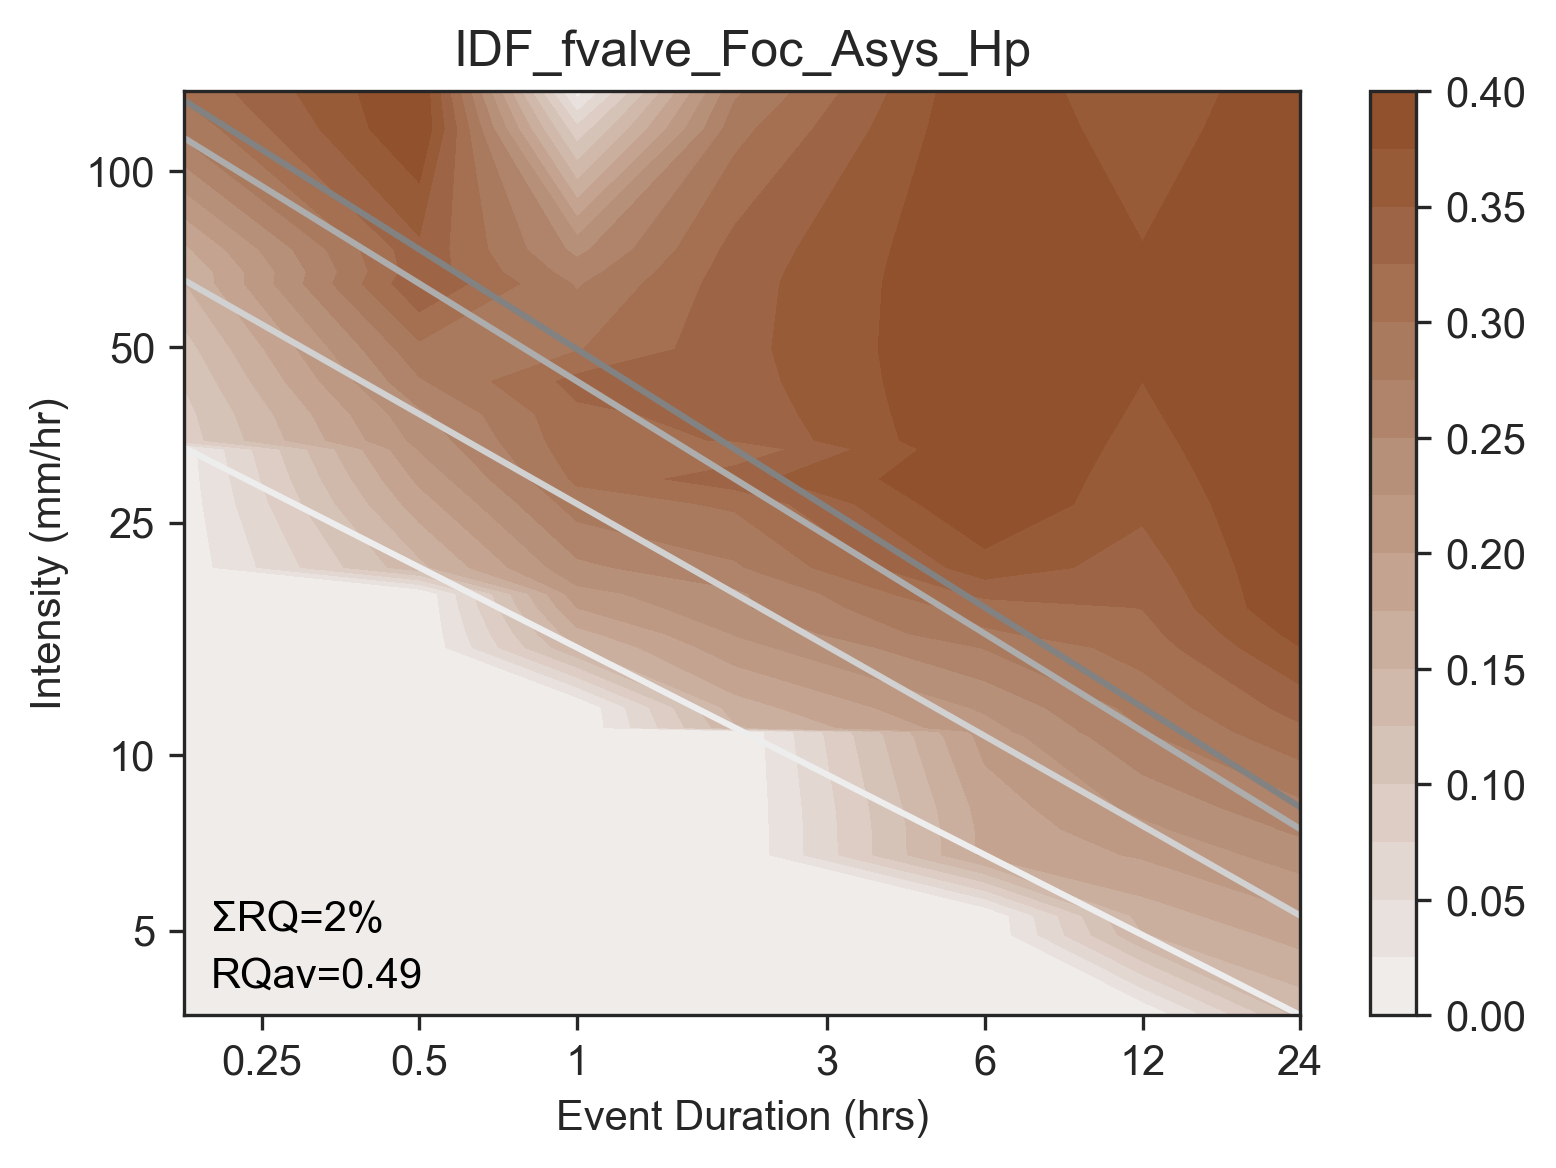

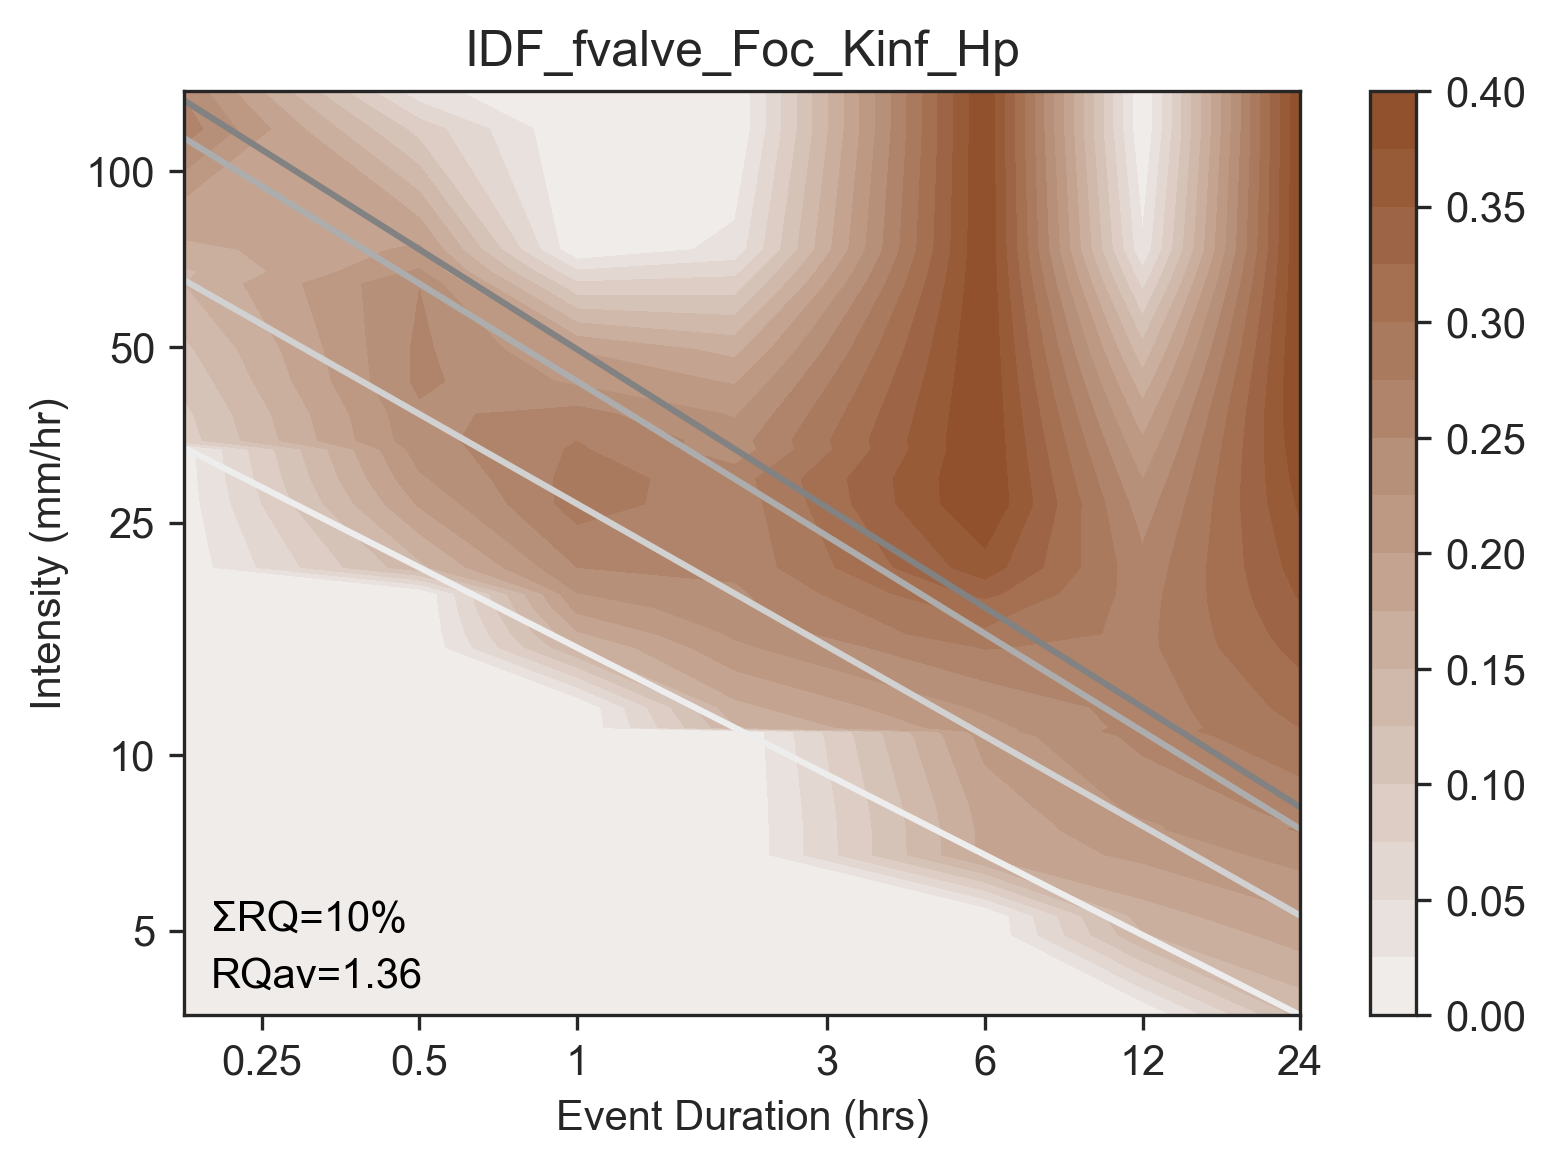

In [190]:
import os
import itertools
import pdb
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_lowkn.pkl'
#defname = 'IDF_.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False,'hpipe':False}#
#combos = ((1,0,0,0,0,0,0),(0,1,0,0,0,0,0),(0,0,1,0,0,0,0),(0,0,0,1,0,0,0),(0,0,0,0,1,0,0),(0,0,0,0,0,1,0),(0,0,0,0,0,0,1))
#combos = ((1,1,0,0,1,1,0),)#(0,1,0,0,0,0),(0,0,1,0,0,0),(0,0,0,1,0,0),(0,0,0,0,1,0),(0,0,0,0,0,1),
#          (1,1,0,0,1,1),(1,1,0,0,0,1))
#for scenario in scenarios:
#combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]
#combos = ((0,0,0,0,0,0,1),(0,0,1,0,0,0,0))
#combos =((1,1,0,1,1,1,0),)
combos = ((1,1,0,0,1,1,0),(1,1,1,0,0,1,0)) #new build ((1,1,1,0,0,1,0),)#retrofit 
for combo in combos:
    #pdb.set_trace()
    scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False,'hpipe':False}
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    #testname = 'IDF_lowkn'+'_'.join(filtered)+'.pkl'
    testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    #Define the x and y axes
    xticks = [0.25,0.5,1,3, 6,12,24]
    xticks = [np.log10(xticks),xticks]
    yticks = [5,10,25,50,100]
    yticks = [np.log10(yticks),yticks]
    #Define the variables to plot
    pltvars=['pct_stormsewer','LogD','LogI']
    pltvars_delta = pltvars.copy()
    delname = pltvars[0] +'_delta'
    pltvars_delta[0] = delname
    pltdata.loc[:,delname] = defdata.loc[:,pltvars[0]] - pltdata.loc[:,pltvars[0]]
    #pdb.set_trace()
    #pltvars=['RQ_av','LogD','LogI']
    #Determine the average risk quotients, sum as a % of the base-case, av as actual value
    bcRQsum = defdata.RQ_sum.sum()
    RQs = [pltdata.RQ_sum.sum()/bcRQsum,pltdata.RQ_av.mean()]
    #Define other parameters
    #Limit of interpolation - values outside of these limits will be set to these. Use "none" for no limits
    hilim = 0.4#np.round(max(pltdata.loc[:,delname]),decimals=2)
    lolim = 0.0#np.round(min(pltdata.loc[:,delname]),decimals=2)
    interplims = [lolim,hilim]
    #interplims = [0.,3.5]
    vlims = [-0.4,0.4]
    #vlims = [lolim,hilim]#[0.15,3.5]#
    #pdb.set_trace()
    #define the colormap - default is brown-blue
    #cmap = None
    #if lolim<0:
    #    cmap = sns.diverging_palette(250, 30, l=40,s=80,center="light", as_cmap=True)
    #else: 
    #    cmap = sns.light_palette('#8f4e27', as_cmap=True)
    cmap = sns.diverging_palette(250, 30, l=40,s=80,center="light", as_cmap=True)
        #cmap = sns.light_palette("seagreen", as_cmap=True)
    #cmap = sns.cubehelix_palette(start=.75, rot=-.5,light=0.85, as_cmap=True)
    #cmap = sns.cubehelix_palette(n_colors = 7,start=1.40, rot=-0.9,gamma = 0.3, hue = 0.9, dark=0.1, light=.95,as_cmap=True,reverse=True)
    bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) 
    fig,ax = bc.plot_idfs(pltdata,pltvars=pltvars_delta,cmap=cmap,vlims=vlims,interplims=interplims,
                          xticks=xticks,yticks=yticks,figsize=(6,4))
    ax.set_xlabel('Event Duration (hrs)')
    ax.set_ylabel('Intensity (mm/hr)')
    #figname = 'IDF_delta_'+str(scenario)
    figname = 'IDF_'+'_'.join(filtered)
    ax.set_title(figname)
    #Annotate the risk quotients
    ax.annotate('ΣRQ='+f'{RQs[0]:.0%}',xy= (np.log10(0.2),np.log10(5)),color = 'k')
    ax.annotate('RQav='+f'{RQs[1]:.2f}',xy= (np.log10(0.2),np.log10(4)),color = 'k')           
    figpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
    #
    fig.savefig(figpath+figname+'.pdf',format='pdf')
    #fig.savefig()

In [183]:
#Find best scenarios
import os
import itertools
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False, 'hpipe':False}
#combos = ((0,0,0,1,0,0),)#((0,0,0,1,0,0),(0,1,0,0,0,0),(0,1,0,1,0,0))
#combos = ((0,0,0,0,0,0,0),(1,0,0,0,0,0,0),(0,1,0,0,0,0,0),(0,0,1,0,0,0,0),(0,0,0,1,0,0,0),(0,0,0,0,1,0,0),
#          (0,0,0,0,0,1,0),(0,0,0,0,0,0,1))
#n
combos = ((1,1,0,0,1,1,0),) #new build ((1,1,1,0,0,1,0),)#retrofit 
#for scenario in scenarios:
#combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]
scenario_list = pd.DataFrame(columns=['RQ_sum','RQ_av'])
for combo in combos:
    #pdb.set_trace()
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    bcRQsum = defdata.RQ_sum.sum()
    scenario_list.loc[testname[4:-4],'RQ_sum'] = pltdata.RQ_sum.sum()/bcRQsum
    scenario_list.loc[testname[4:-4],'RQ_av'] =pltdata.RQ_av.mean()
    scenario_list.loc[testname[4:-4],'pct_Qover'] =pltdata.pct_Qover.mean()
    scenario_list.loc[testname[4:-4],'pct_advected'] =pltdata.pct_advected.mean()
scenario_list.sort_values('RQ_sum',ascending=True)[0:25]


RQ_sum     RQ_av  pct_Qover  pct_advected
fvalve_Foc_Asys_Hp  0.021113  0.493881   0.005834      0.035142

In [163]:
#Find best scenarios - retrofit.
#Retrofit-possible scenarios are: fvalve, Foc, Kinf?, Hp
import os
import itertools
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False, 'hpipe':False}
#combos = ((0,0,0,1,0,0),)#((0,0,0,1,0,0),(0,1,0,0,0,0),(0,1,0,1,0,0))
#for scenario in scenarios:
combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]

scenario_list = pd.DataFrame(columns=['RQ_sum','RQ_av'])
for combo in combos:
    #pdb.set_trace()
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    #Skip these ones
    if  (scenario_dict['Dsys'] == True) | (scenario_dict['Asys'] == True)| (scenario_dict['hpipe'] == True):
        continue
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    bcRQsum = defdata.RQ_sum.sum()
    scenario_list.loc[testname[4:-4],'RQ_sum'] = pltdata.RQ_sum.sum()/bcRQsum
    scenario_list.loc[testname[4:-4],'RQ_av'] =pltdata.RQ_av.mean()
    scenario_list.loc[testname[4:-4],'pct_Qover'] =pltdata.pct_Qover.mean()
    scenario_list.loc[testname[4:-4],'pct_advected'] =pltdata.pct_advected.mean()
scenario_list.sort_values('RQ_sum',ascending=True)[0:25]


RQ_sum     RQ_av  pct_Qover  pct_advected
fvalve_Foc_Kinf_Hp  0.105519  1.359851   0.030446      0.089909
fvalve_Kinf_Hp      0.105519  1.359851   0.030446      0.252190
fvalve_Foc_Kinf      0.22928  2.091463   0.065025      0.115472
fvalve_Kinf          0.22928  2.091464   0.065025      0.259747
Foc_Kinf_Hp         0.232218  0.478076   0.030446      0.097976
Foc_Kinf            0.258114  0.696361   0.065025      0.122282
Foc_Hp              0.393389  0.811072   0.081643      0.113876
Foc                 0.527671  1.304001   0.135527      0.158249
fvalve_Foc_Hp       0.547295  2.228071   0.081643      0.111940
fvalve_Hp           0.547295  2.228071   0.081643      0.224505
Kinf                0.809977  1.318788   0.065025      0.271335
Kinf_Hp             0.816242  1.171059   0.030446      0.265702
fvalve_Foc          0.858793  2.683988   0.135527      0.156783
fvalve              0.858793  2.683989   0.135527      0.250917
Hp                  0.932333  1.249379   0.081643      0.228828
                         1.0  1.651069   0.135527      0.254221

In [ ]:
defdata
#len(combos)

In [ ]:
pltdata

In [175]:
#Find best scenarios - low exfiltration
import os
import itertools
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_lowkn.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False, 'hpipe':False}
#combos = ((0,0,0,1,0,0),)#((0,0,0,1,0,0),(0,1,0,0,0,0),(0,1,0,1,0,0))
combos = ((0,0,0,0,0,0,0),(1,0,0,0,0,0,0),(0,1,0,0,0,0,0),(0,0,1,0,0,0,0),(0,0,0,1,0,0,0),(0,0,0,0,1,0,0),
          (0,0,0,0,0,1,0),(0,0,0,0,0,0,1))
#for scenario in scenarios:
#combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]
scenario_list = pd.DataFrame(columns=['RQ_sum','RQ_av'])
for combo in combos:
    #pdb.set_trace()
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    #testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    testname = 'IDF_lowkn'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    bcRQsum = defdata.RQ_sum.sum()
    scenario_list.loc[testname[4:-4],'RQ_sum'] = pltdata.RQ_sum.sum()/bcRQsum
    scenario_list.loc[testname[4:-4],'RQ_av'] =pltdata.RQ_av.mean()
    scenario_list.loc[testname[4:-4],'pct_Qover'] =pltdata.pct_Qover.mean()
    scenario_list.loc[testname[4:-4],'pct_advected'] =pltdata.pct_advected.mean()
scenario_list.sort_values('RQ_sum',ascending=True)[0:25]


RQ_sum     RQ_av  pct_Qover  pct_advected
lowknFoc     0.387104  0.763618   0.135527      0.157829
lowknAsys    0.530029  0.672169   0.040061      0.163973
lowknDsys    0.690216  0.949948   0.135527      0.198687
lowknfvalve  0.776211  2.683989   0.135527      0.159728
lowknKinf    0.885115  1.095677   0.065025      0.269777
lowknHp      0.983721  0.950152   0.081643      0.227285
lowkn             1.0   1.15527   0.135527      0.252706
lowknhpipe   1.010981  1.135689   0.135527      0.243747

In [3]:
#Find best scenarios - retrofit.
#Retrofit-possible scenarios are: fvalve, Foc, Kinf?, Hp
import os
import itertools
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_.pkl'
#defname = 'IDF_lowkn.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False, 'hpipe':False}
#combos = ((0,0,0,1,0,0),)#((0,0,0,1,0,0),(0,1,0,0,0,0),(0,1,0,1,0,0))
#for scenario in scenarios:
combos = list(itertools.product([0,1],repeat=7))
#combos = combos = ((1,1,0,0,1,1,0),)
#combos = ((1,0,0,0,0,0,0),(0,1,0,0,0,0,0),(0,0,1,0,0,0,0),(0,0,0,1,0,0,0),(0,0,0,0,1,0,0),
#          (0,0,0,0,0,1,0),(0,0,0,0,0,0,1),(1,1,0,1,1,1,0),(1,1,1,0,0,1,0))
scenario_list = pd.DataFrame(columns=['RQ_sum','RQ_av'])
for combo in combos:
    #pdb.set_trace()
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    #testname = 'IDF_lowkn'+'_'.join(filtered)+'.pkl'
    testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    #Skip these ones
    if  (scenario_dict['Dsys'] == True) | (scenario_dict['Asys'] == True)| (scenario_dict['hpipe'] == True):
        continue
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    bcRQsum = defdata.RQ_sum.sum()
    scenario_list.loc[testname[4:-4],'RQ_sum'] = pltdata.RQ_sum.sum()/bcRQsum
    scenario_list.loc[testname[4:-4],'RQ_av'] =pltdata.RQ_av.mean()
    scenario_list.loc[testname[4:-4],'pct_Qover'] =pltdata.pct_Qover.mean()
    scenario_list.loc[testname[4:-4],'pct_advected'] =pltdata.pct_advected.mean()
scenario_list.sort_values('RQ_sum',ascending=True)[0:25]


FileNotFoundError: [Errno 2] No such file or directory: 'inputfiles/Pine8th_BC.xlsx'

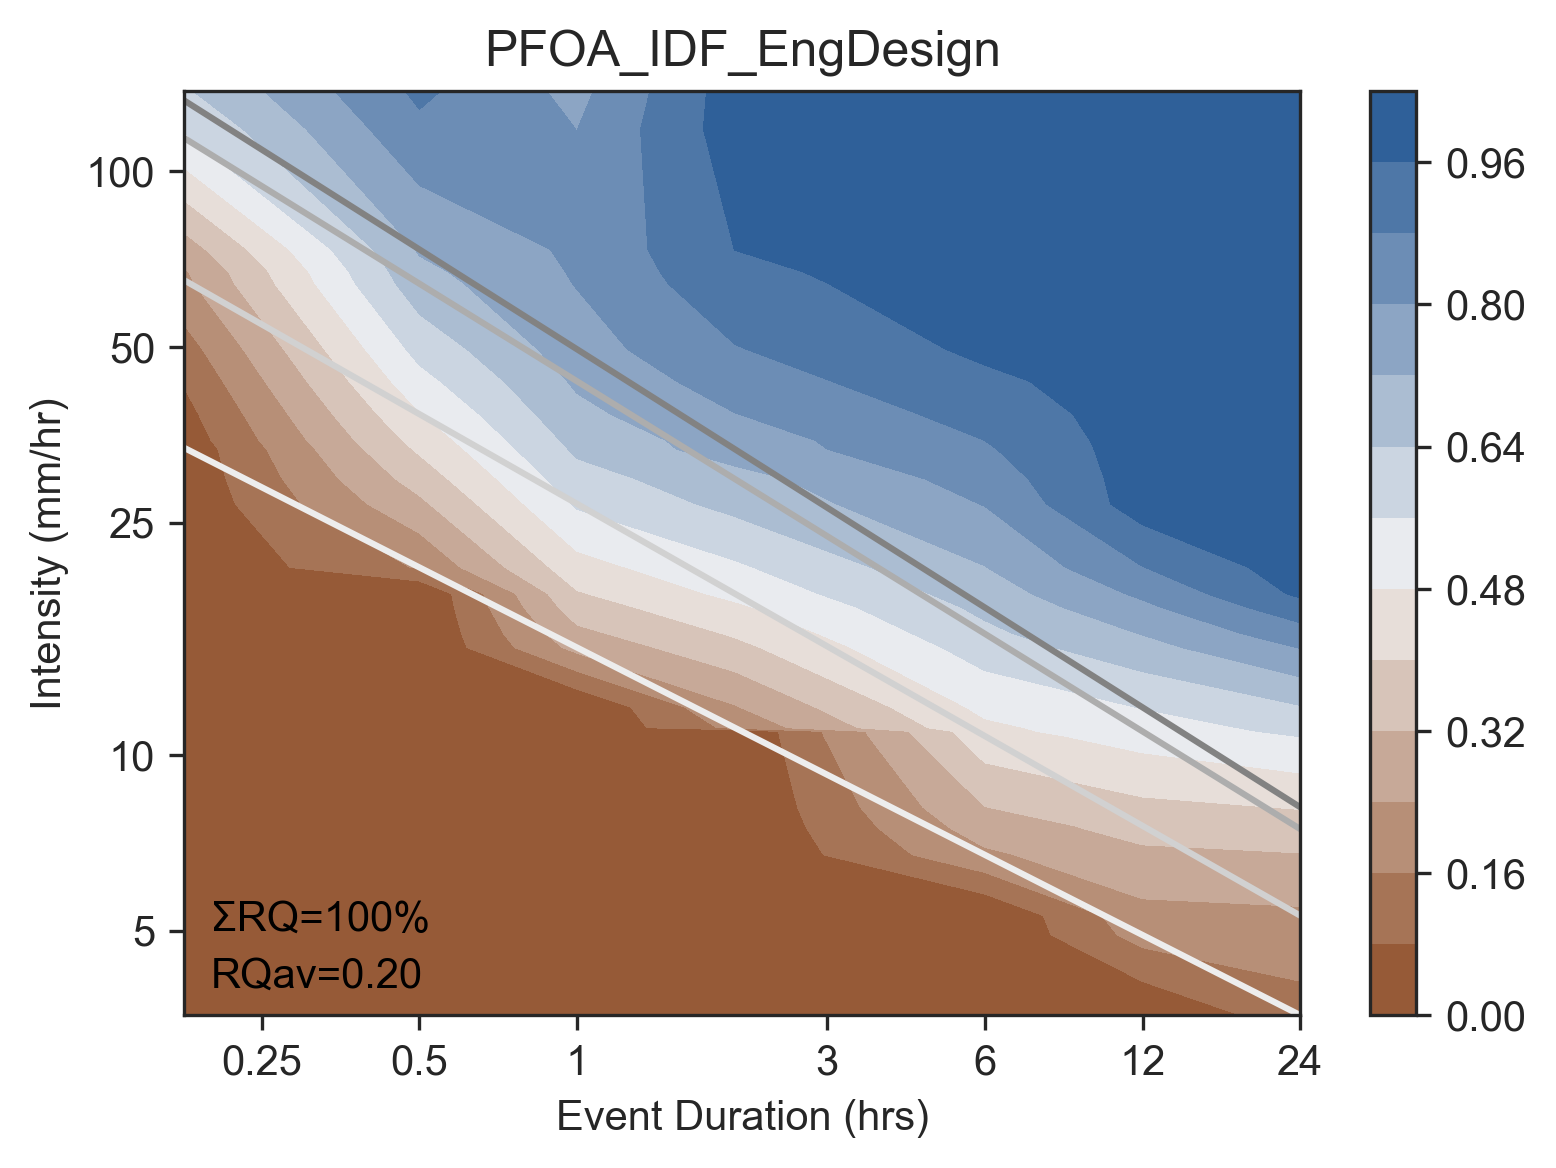

In [39]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set_style('ticks')
import matplotlib.pyplot as plt
#This is the name of the python module containing the Bioretention Blues submodel.
from BioretentionBlues import BCBlues
import os
import itertools
import pdb
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/Pine8th/EngDesign_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/Pine8th/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/Pine8th/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_EngDesign.pkl'
#defname = 'IDF_.pkl'
defdf = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 
                         'Asys':False, 'Hp':False, 'hpipe':False, 'amend':False}
#combos = ((1,0,0,0,0,0,0,0),(0,1,0,0,0,0,0,0),(0,0,1,0,0,0,0,0),(0,0,0,1,0,0,0,0),(0,0,0,0,1,0,0,0),
#          (0,0,0,0,0,1,0,0),(0,0,0,0,0,0,1,0),(0,0,0,0,0,0,0,1))
#combos = ((1,0,0,0,0,0,0),)#(0,1,0,0,0,0),(0,0,1,0,0,0),(0,0,0,1,0,0),(0,0,0,0,1,0),(0,0,0,0,0,1),
#          (1,1,0,0,1,1),(1,1,0,0,0,1))
combos = ((0,0,0,0,0,0,0,0,0),)
#for scenario in scenarios:
#combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]
#combos = ((0,0,0,0,0,0,1),(0,0,1,0,0,0,0))
#combos =((0,1,0,0,0,0,0),)
for combo in combos:
    #pdb.set_trace()
    scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 
                         'Asys':False, 'Hp':False, 'hpipe':False, 'amend':False}
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    testname = 'IDF_EngDesign'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_EngDesign_lowKn'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdf = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    #Define the x and y axes
    #pdb.set_trace()
    xticks = [0.25,0.5,1,3, 6,12,24]
    xticks = [np.log10(xticks),xticks]
    yticks = [5,10,25,50,100]
    yticks = [np.log10(yticks),yticks]
    #Define the variables to plot
    for compound in ['PFOA']:#pltdf.index.unique(): #
        pltdata = pltdf.loc[compound,:].copy(deep=True)
        defdata = defdf.loc[compound,:].copy(deep=True)
        pltvars=['pct_stormsewer','LogD','LogI']
        #pltvars=['pct_advected','LogD','LogI']
        pltvars_delta = pltvars.copy()
        delname = pltvars[0] +'_delta'
        pltvars_delta[0] = delname
        pltdata.loc[:,delname] = defdata.loc[:,pltvars[0]] #- pltdata.loc[:,pltvars[0]]
        #pdb.set_trace()
        #pltvars=['RQ_av','LogD','LogI']
        #Determine the average risk quotients, sum as a % of the base-case, av as actual value
        bcRQsum = defdata.RQ_sum.sum()
        RQs = [pltdata.RQ_sum.sum()/bcRQsum,pltdata.RQ_av.mean()]
        #pdb.set_trace()
        #Define other parameters
        #Limit of interpolation - values outside of these limits will be set to these. Use "none" for no limits
        interplims = [0.,1.]
        #interplims = [0.,3.5]
        vlims = [0.0,1.0]#[0.15,3.5]#
        #pdb.set_trace()
        #define the colormap - default is brown-blue
        cmap = None#sns.diverging_palette(250, 30, l=40,s=80,center="light", as_cmap=True)
            #cmap = sns.light_palette("seagreen", as_cmap=True)
        #cmap = sns.cubehelix_palette(start=.75, rot=-.5,light=0.85, as_cmap=True)
        #cmap = sns.cubehelix_palette(n_colors = 7,start=1.40, rot=-0.9,gamma = 0.3, hue = 0.9, dark=0.1, light=.95,as_cmap=True,reverse=True)
        bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) 
        fig,ax = bc.plot_idfs(pltdata,pltvars=pltvars_delta,cmap=cmap,vlims=vlims,interplims=interplims,
                              xticks=xticks,yticks=yticks,figsize=(6,4))
        ax.set_xlabel('Event Duration (hrs)')
        ax.set_ylabel('Intensity (mm/hr)')
        #figname = 'IDF_delta_'+str(scenario)
        figname = compound+'_IDF_EngDesign'+'_'.join(filtered)
        ax.set_title(figname)
        #Annotate the risk quotients
        ax.annotate('ΣRQ='+f'{RQs[0]:.0%}',xy= (np.log10(0.2),np.log10(5)),color = 'k')
        ax.annotate('RQav='+f'{RQs[1]:.2f}',xy= (np.log10(0.2),np.log10(4)),color = 'k')           
        figpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
        #
        fig.savefig(figpath+figname+'.pdf',format='pdf')
    #fig.savefig()

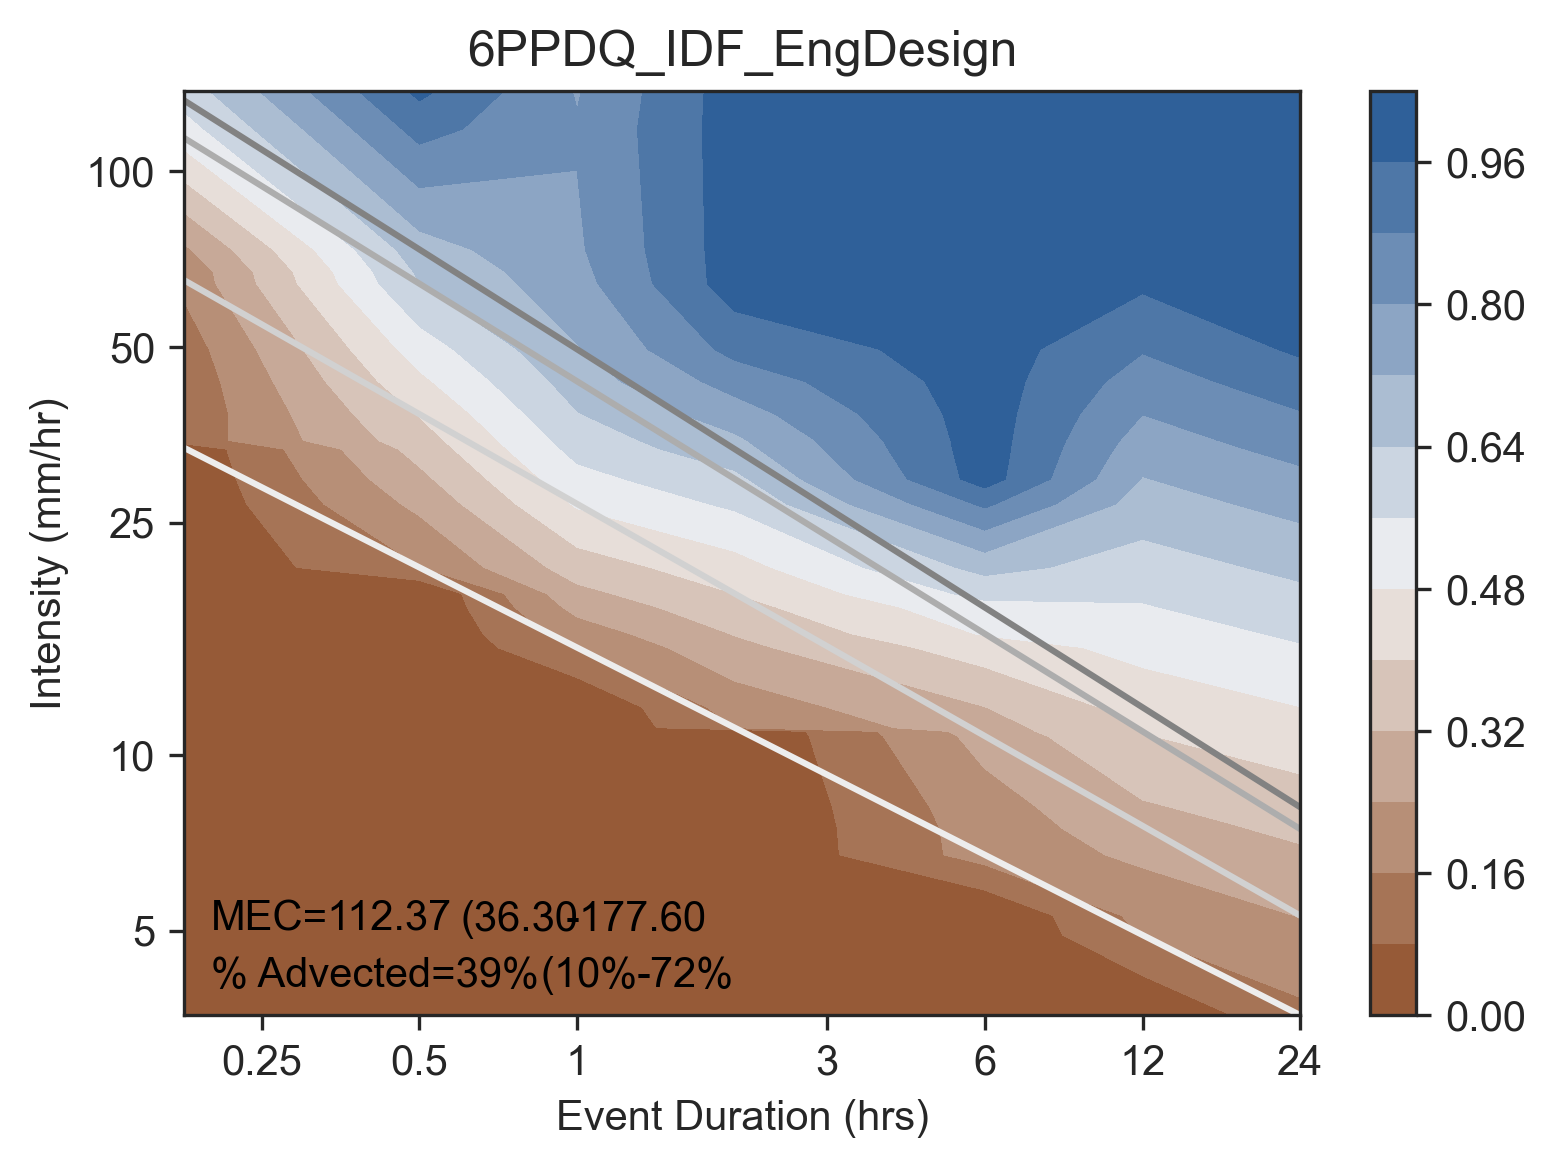

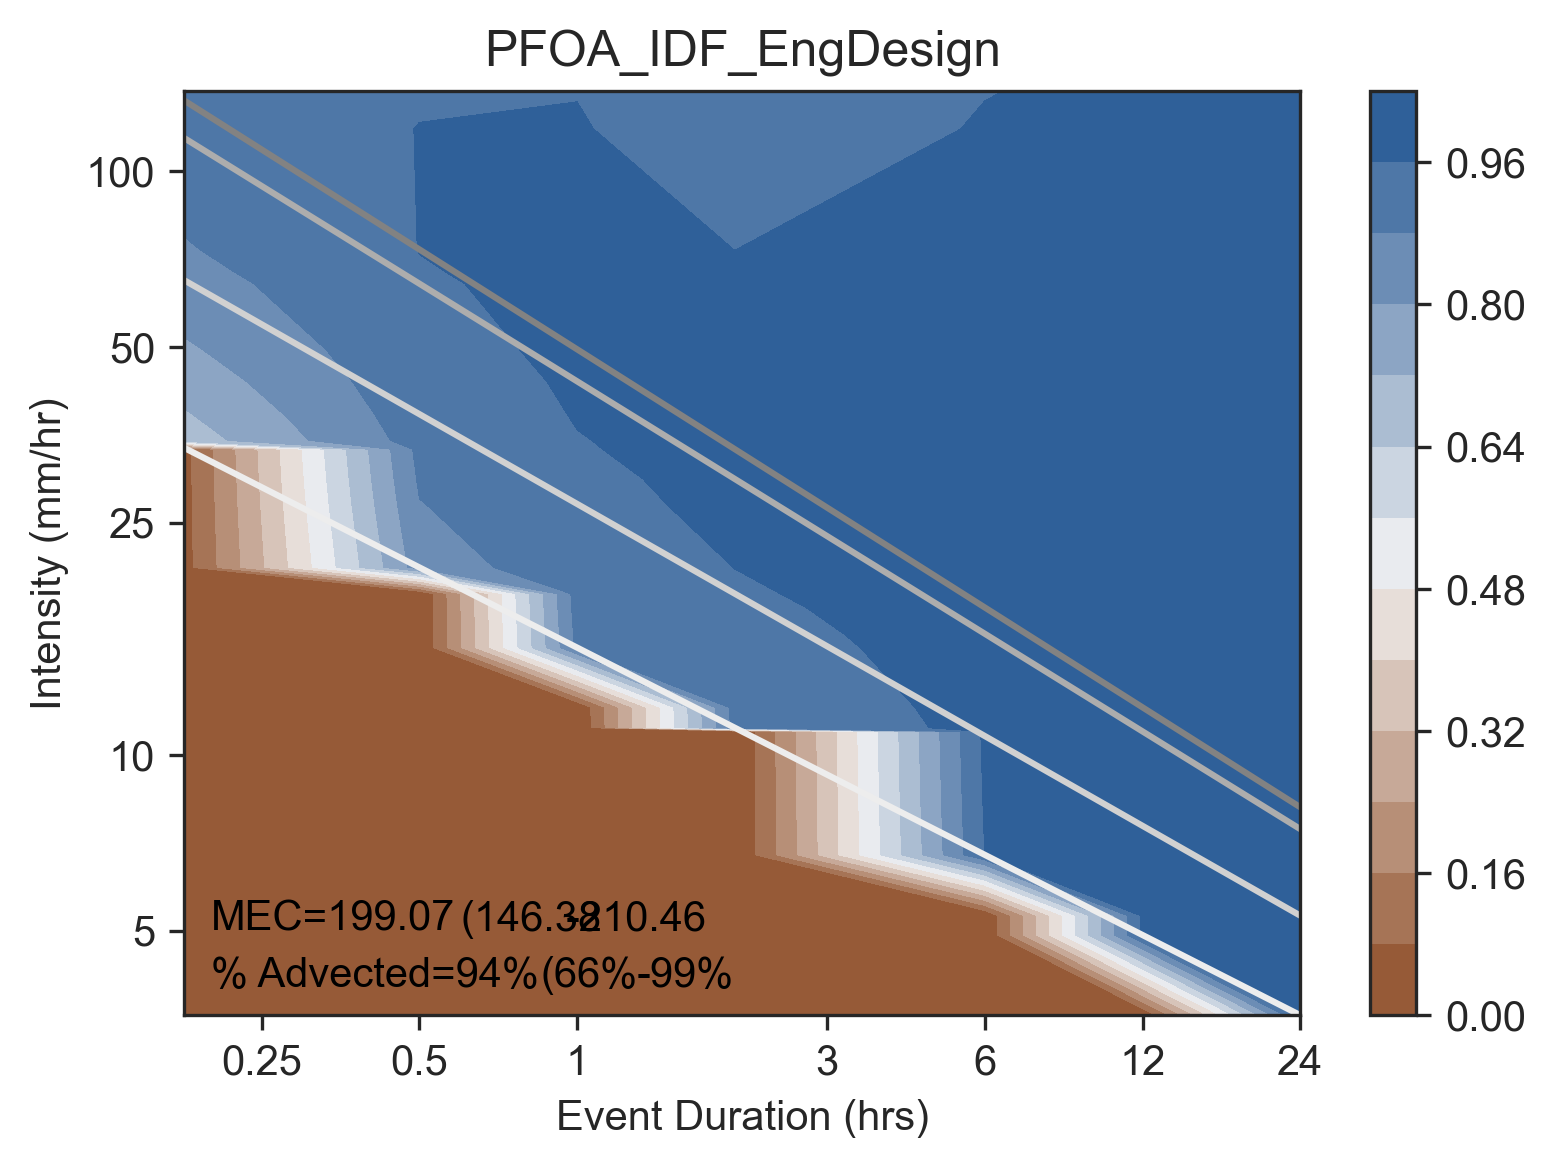

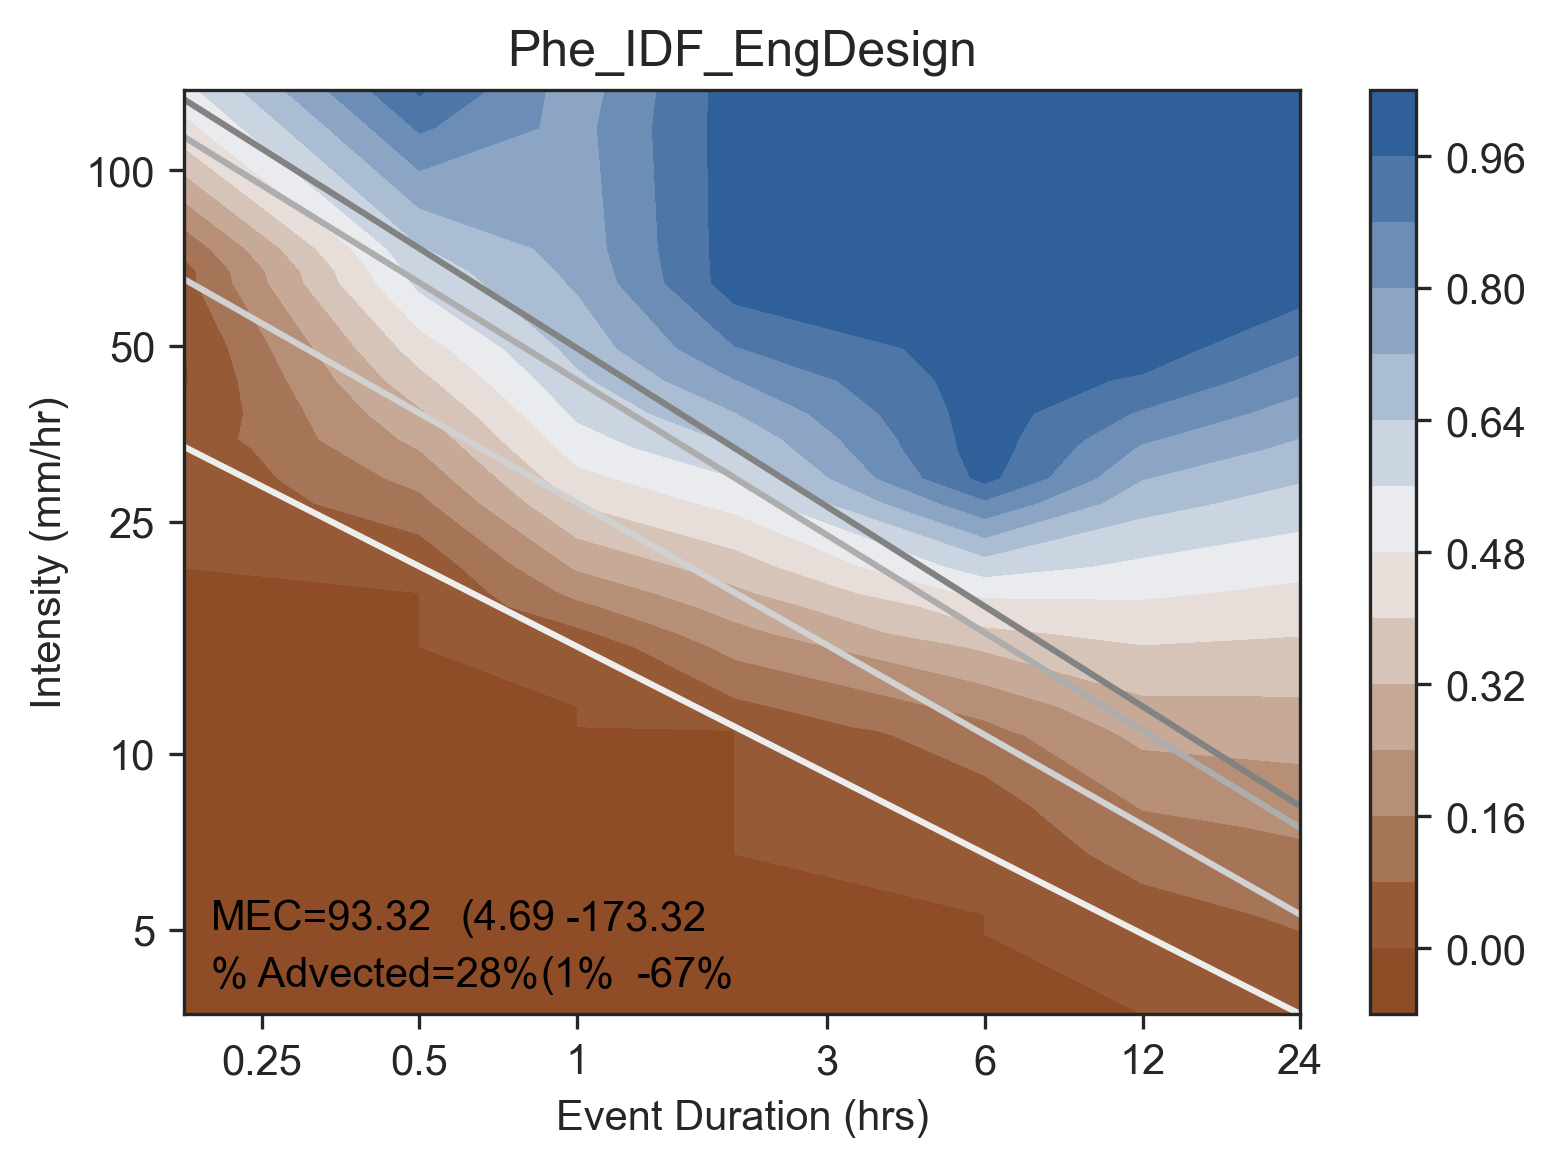

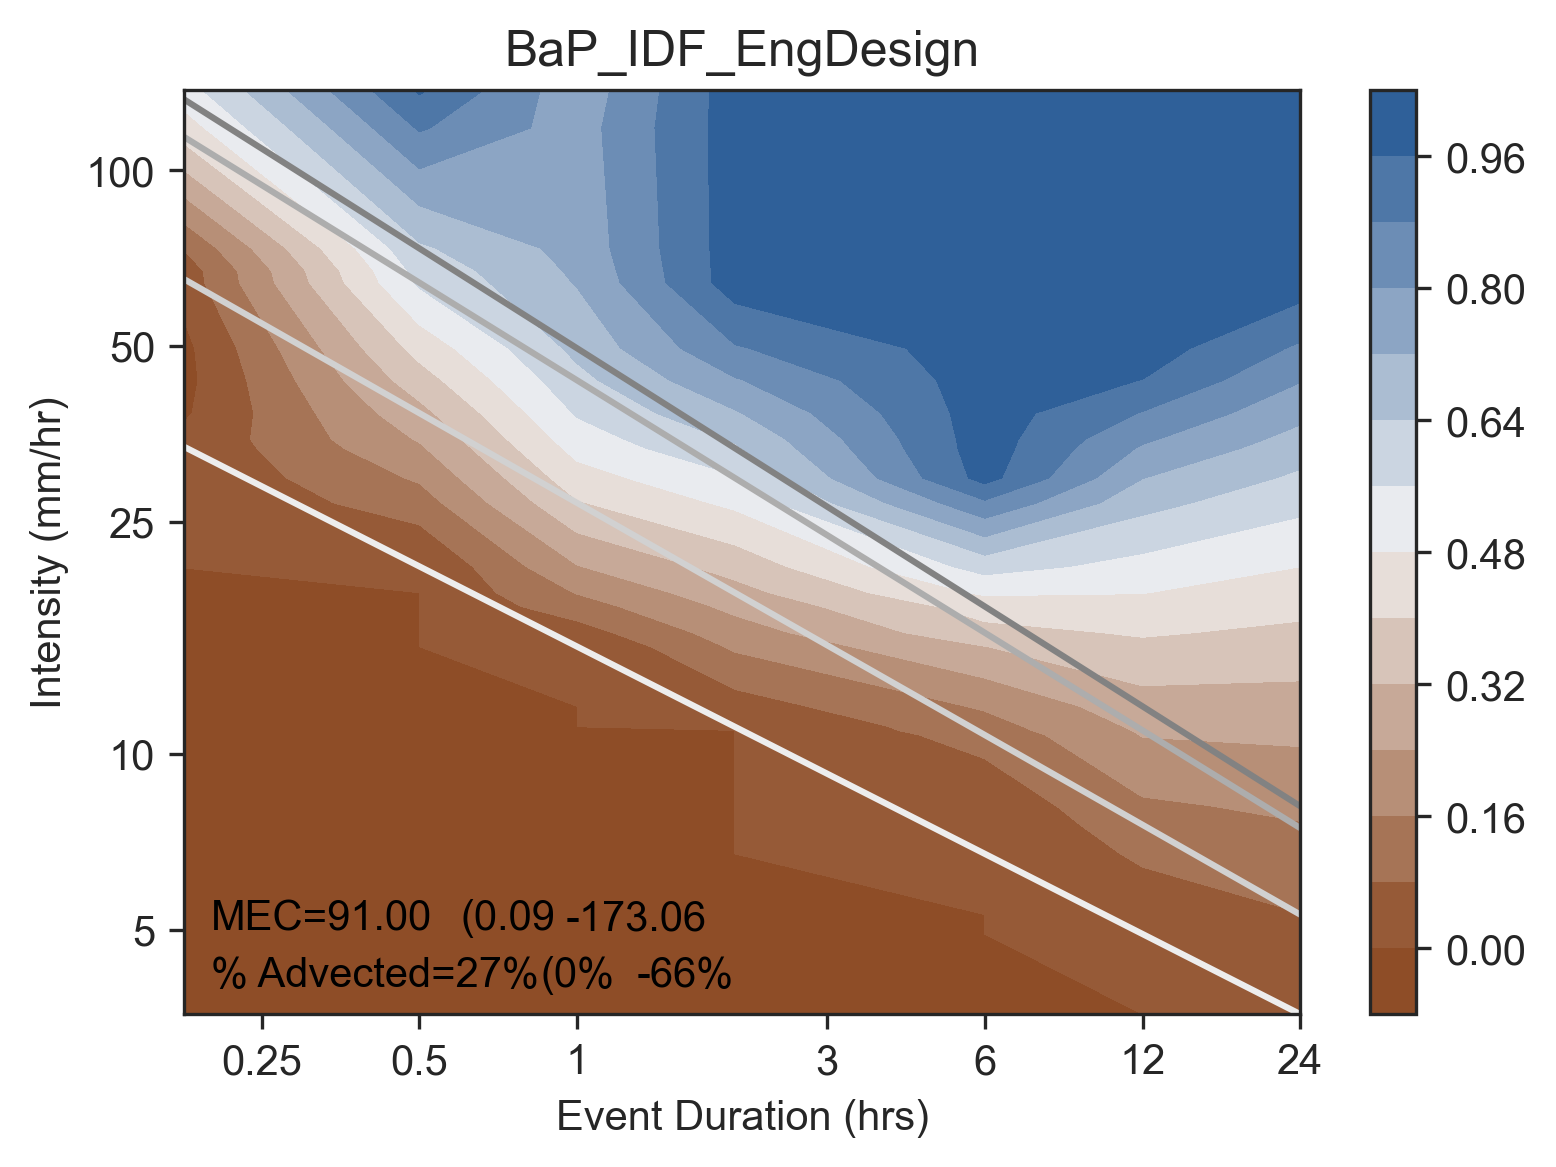

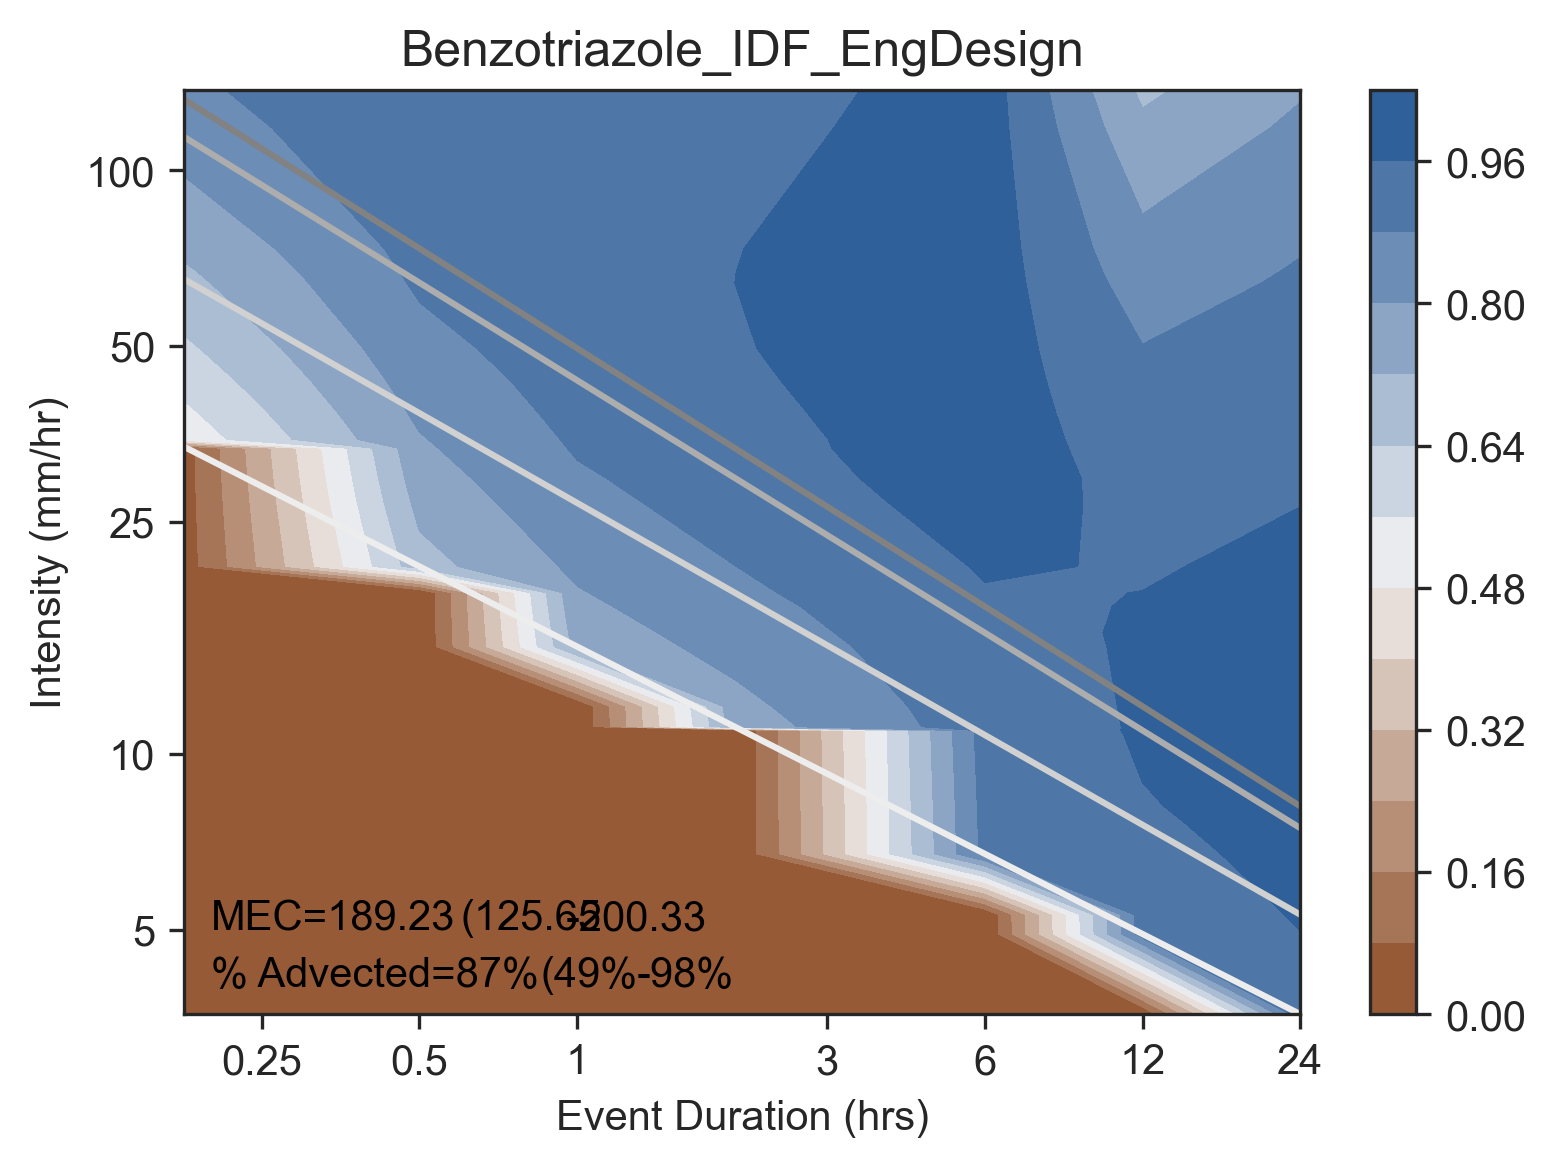

In [44]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set_style('ticks')
import matplotlib.pyplot as plt
#This is the name of the python module containing the Bioretention Blues submodel.
from BioretentionBlues import BCBlues
import os
import itertools
import pdb
#Plot system performance on IDF curves. This plots the actual values 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/Pine8th/EngDesign_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/Pine8th/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/Pine8th/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_EngDesign.pkl'
#defname = 'IDF_.pkl'
defdf = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 
                         'Asys':False, 'Hp':False, 'hpipe':False, 'amend':False}
#combos = ((0,0,0,0,0,0,0,0,0),(1,0,0,0,0,0,0,0),(0,1,0,0,0,0,0,0),(0,0,1,0,0,0,0,0),(0,0,0,1,0,0,0,0),(0,0,0,0,1,0,0,0),
#          (0,0,0,0,0,1,0,0),(0,0,0,0,0,0,1,0),(0,0,0,0,0,0,0,1))
#combos = ((1,0,0,0,0,0,0),)#(0,1,0,0,0,0),(0,0,1,0,0,0),(0,0,0,1,0,0),(0,0,0,0,1,0),(0,0,0,0,0,1),
#          (1,1,0,0,1,1),(1,1,0,0,0,1))
combos = ((0,0,0,0,0,0,0,0,0),)
#for scenario in scenarios:
#combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]
#combos = ((0,0,0,0,0,0,1),(0,0,1,0,0,0,0))
#combos =((0,1,0,0,0,0,0),)
for combo in combos:
    #pdb.set_trace()
    scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 
                         'Asys':False, 'Hp':False, 'hpipe':False, 'amend':False}
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    testname = 'IDF_EngDesign'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_EngDesign_lowKn'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdf = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    #Define the x and y axes
    #pdb.set_trace()
    xticks = [0.25,0.5,1,3, 6,12,24]
    xticks = [np.log10(xticks),xticks]
    yticks = [5,10,25,50,100]
    yticks = [np.log10(yticks),yticks]
    #Define the variables to plot
    for compound in pltdf.index.unique(): #
        pltdata = pltdf.loc[compound,:].copy(deep=True)
        defdata = defdf.loc[compound,:].copy(deep=True)
        #pltvars=['pct_stormsewer','LogD','LogI']
        pltvars=['pct_advected','LogD','LogI']
        pltvars_delta = pltvars.copy()
        delname = pltvars[0] +'_delta'
        pltvars_delta[0] = delname
        pltdata.loc[:,delname] = defdata.loc[:,pltvars[0]]# - pltdata.loc[:,pltvars[0]]
        #pdb.set_trace()
        #pltvars=['RQ_av','LogD','LogI']
        #Determine the average risk quotients, sum as a % of the base-case, av as actual value
        bcRQsum = defdata.RQ_sum.sum()
        RQs = [pltdata.MEC_ngl.mean(),pltdata.MEC_ngl.min(),pltdata.MEC_ngl.max(),
               pltdata.pct_advected.mean(),pltdata.pct_advected.min(),pltdata.pct_advected.max()]
        #pdb.set_trace()
        #Define other parameters
        #Limit of interpolation - values outside of these limits will be set to these. Use "none" for no limits
        interplims = [0.,1.]
        #interplims = [0.,3.5]
        vlims = [0.0,1.0]#[0.15,3.5]#
        #pdb.set_trace()
        #define the colormap - default is brown-blue
        cmap = None
            #cmap = sns.light_palette("seagreen", as_cmap=True)
        #cmap = sns.cubehelix_palette(start=.75, rot=-.5,light=0.85, as_cmap=True)
        #cmap = sns.cubehelix_palette(n_colors = 7,start=1.40, rot=-0.9,gamma = 0.3, hue = 0.9, dark=0.1, light=.95,as_cmap=True,reverse=True)
        bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) 
        fig,ax = bc.plot_idfs(pltdata,pltvars=pltvars_delta,cmap=cmap,vlims=vlims,interplims=interplims,
                              xticks=xticks,yticks=yticks,figsize=(6,4))
        ax.set_xlabel('Event Duration (hrs)')
        ax.set_ylabel('Intensity (mm/hr)')
        #figname = 'IDF_delta_'+str(scenario)
        figname = compound+'_IDF_EngDesign'+'_'.join(filtered)
        ax.set_title(figname)
        #Annotate the risk quotients
        ax.annotate('MEC='+f'{RQs[0]:.2f}',xy= (np.log10(0.2),np.log10(5)),color = 'k')
        ax.annotate('('+f'{RQs[1]:.2f}',xy= (np.log10(0.60),np.log10(5)),color = 'k')
        ax.annotate('-'+f'{RQs[2]:.2f}',xy= (np.log10(0.95),np.log10(5)),color = 'k')
        ax.annotate('% Advected='+f'{RQs[3]:.0%}',xy= (np.log10(0.2),np.log10(4)),color = 'k')   
        ax.annotate('('+f'{RQs[4]:.0%}',xy= (np.log10(0.85),np.log10(4)),color = 'k')   
        ax.annotate('-'+f'{RQs[5]:.0%}',xy= (np.log10(1.3),np.log10(4)),color = 'k')   
        figpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
        #
        #fig.savefig(figpath+figname+'.pdf',format='pdf')
    #fig.savefig()

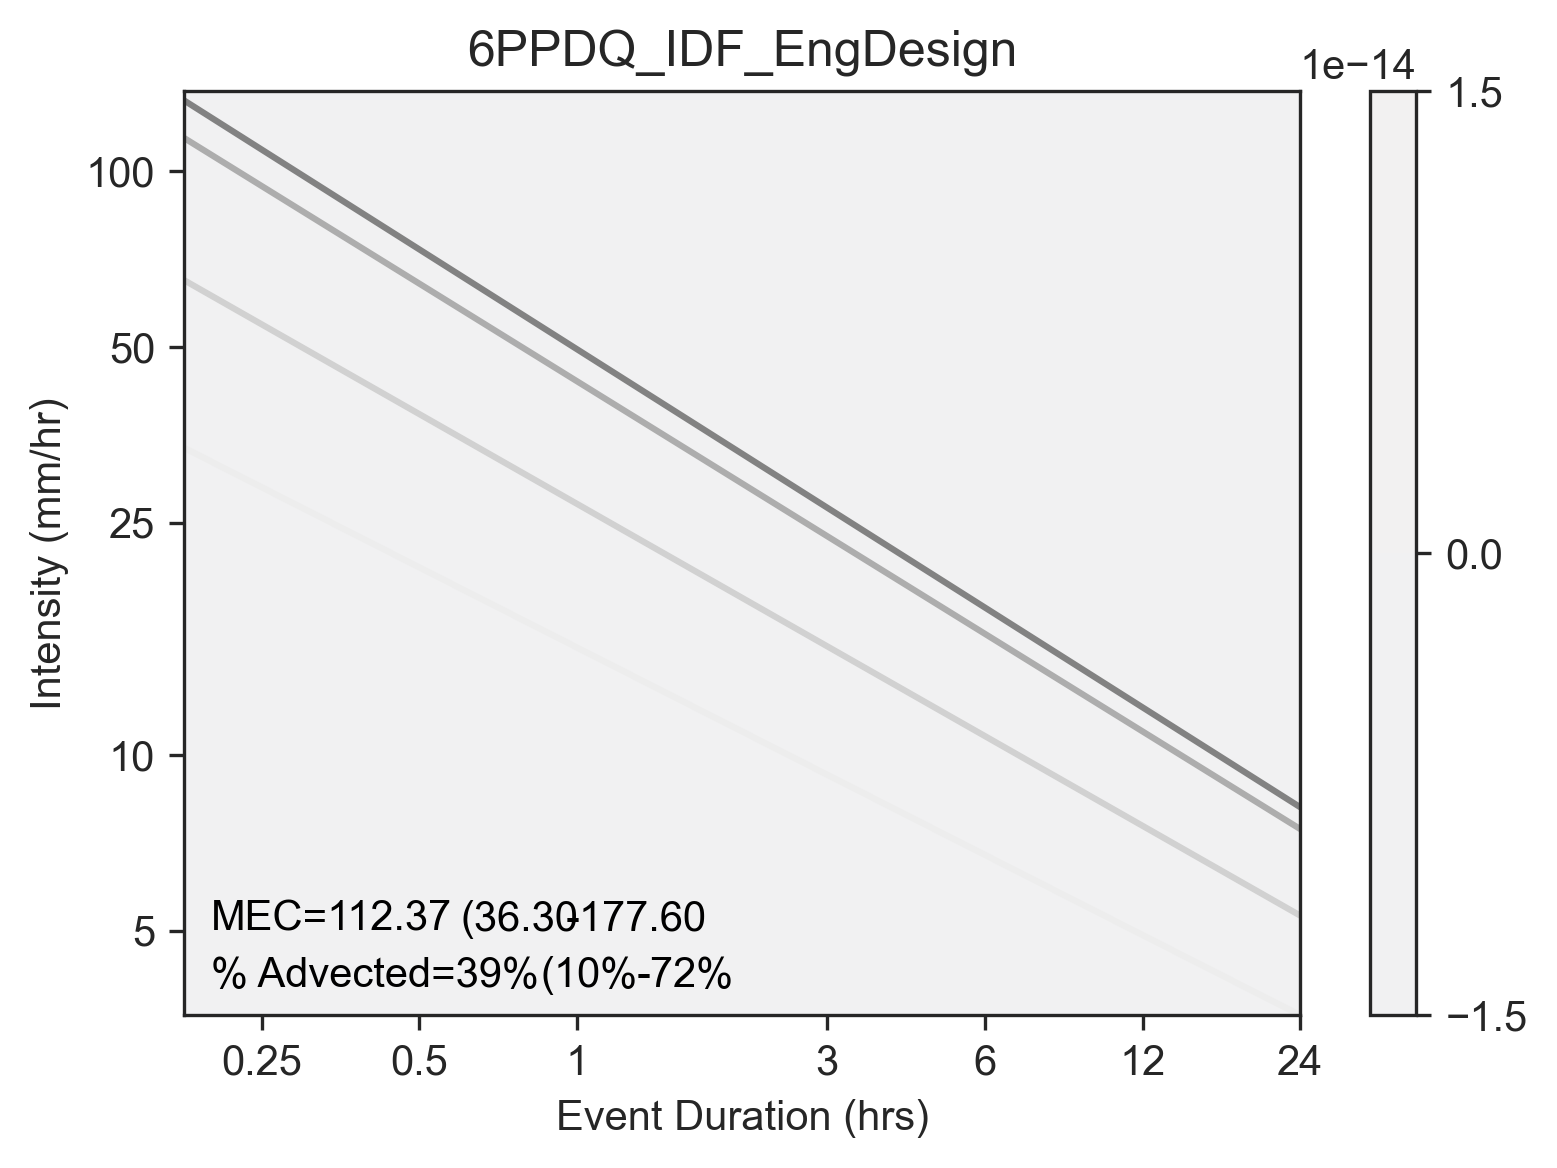

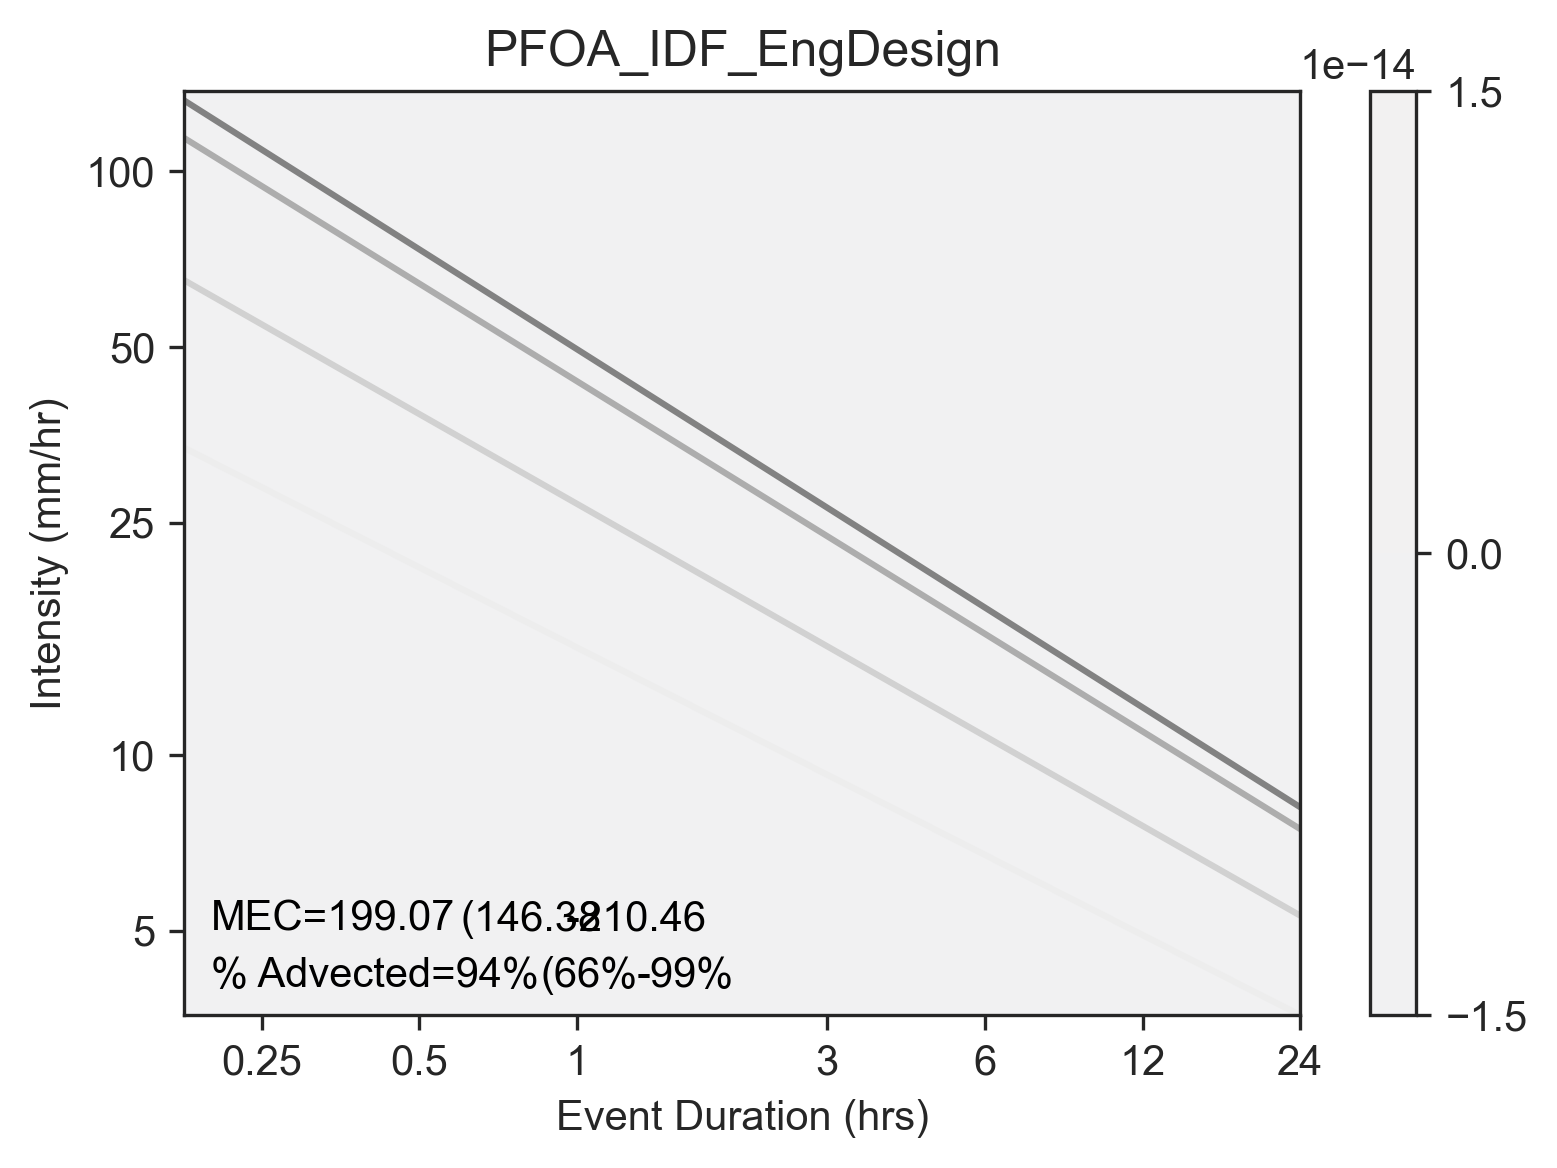

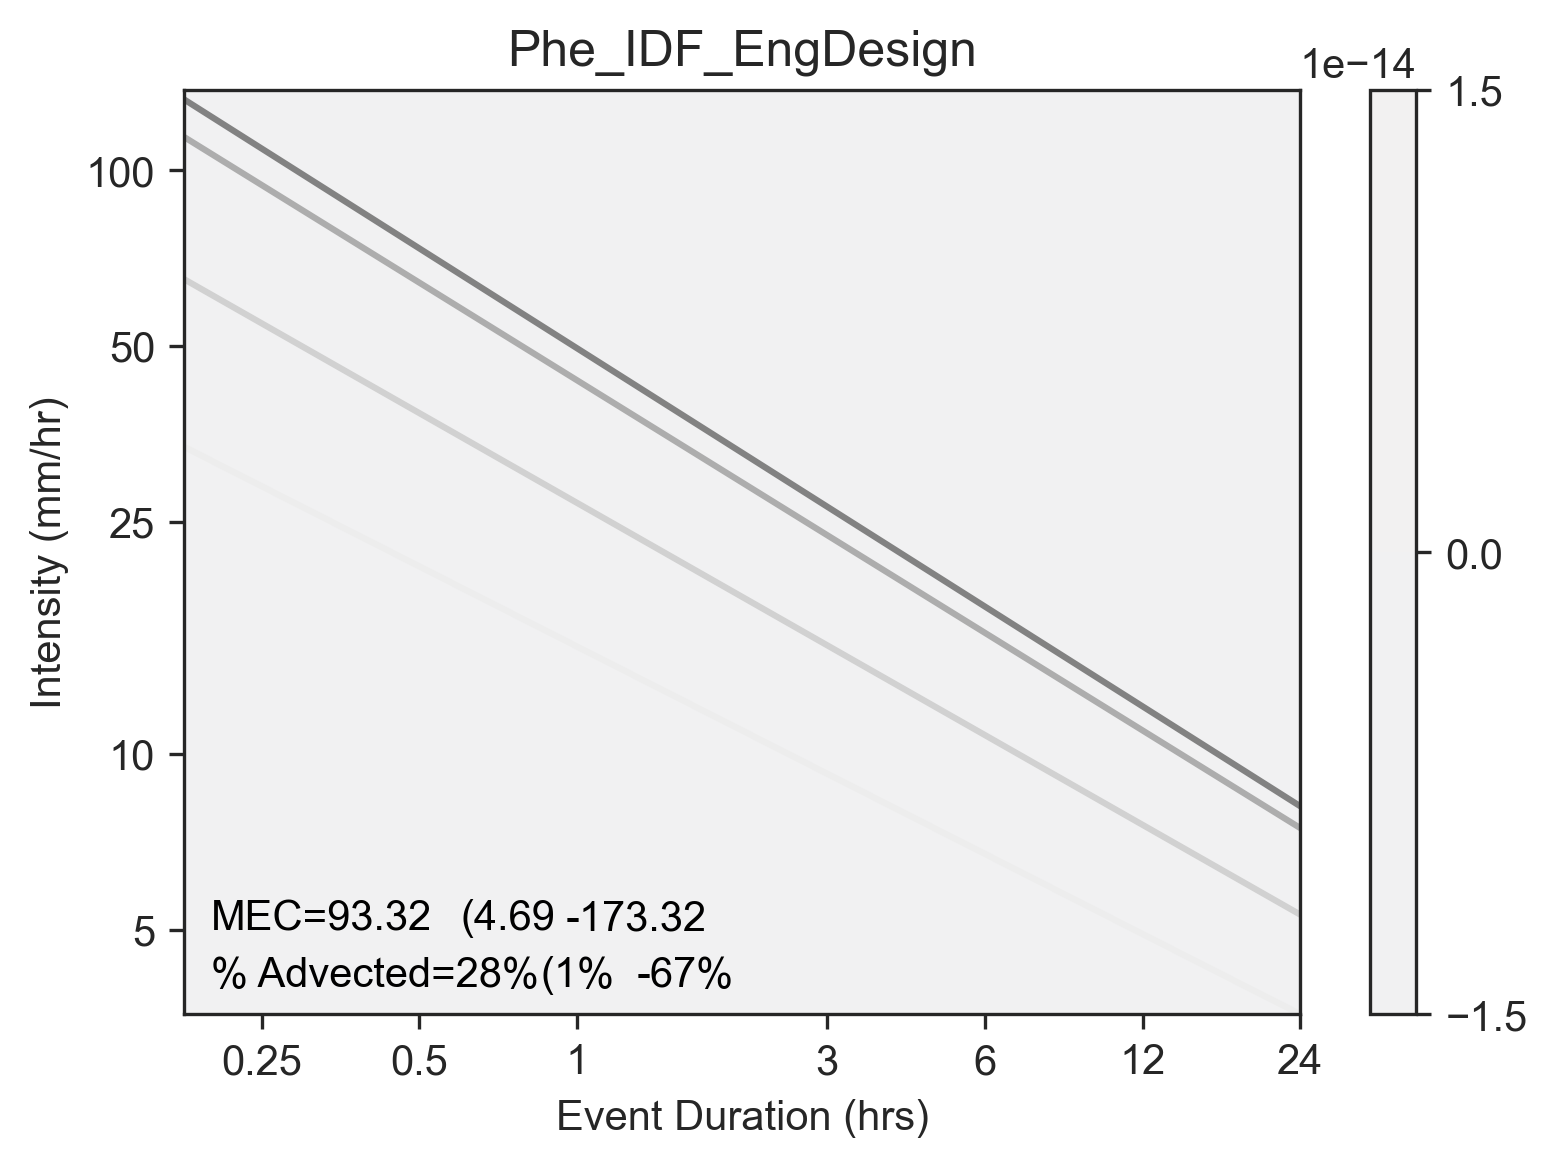

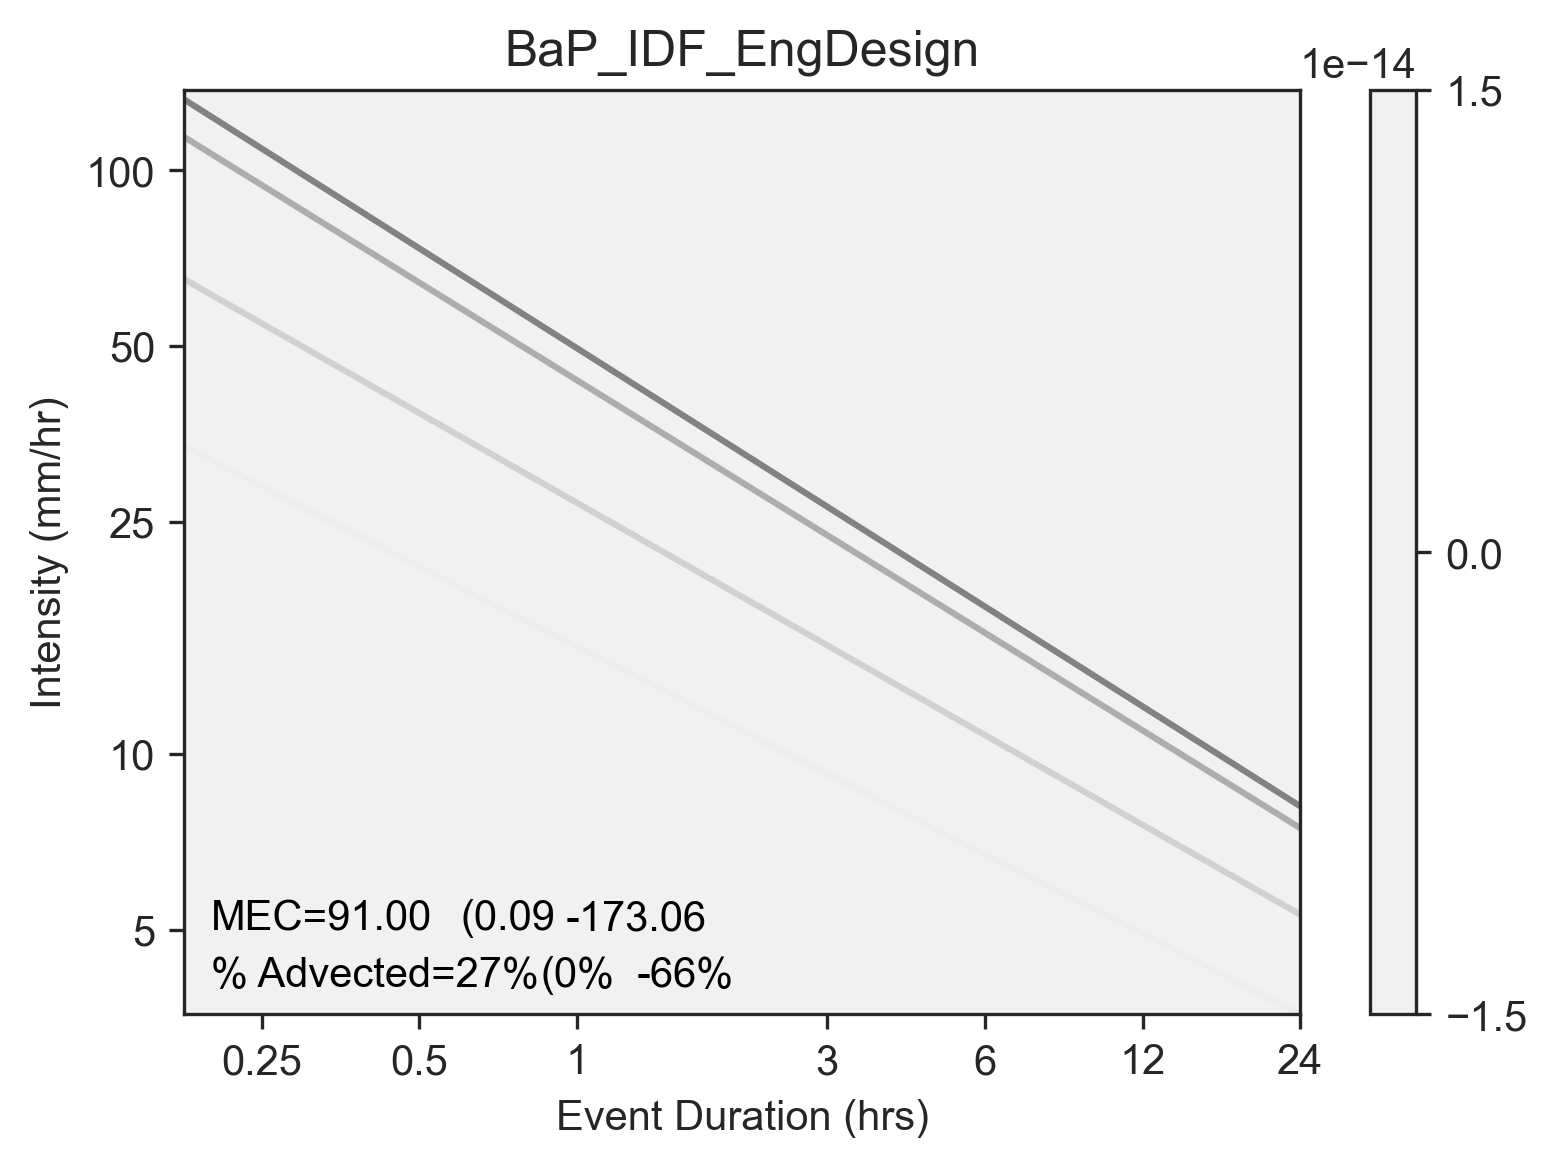

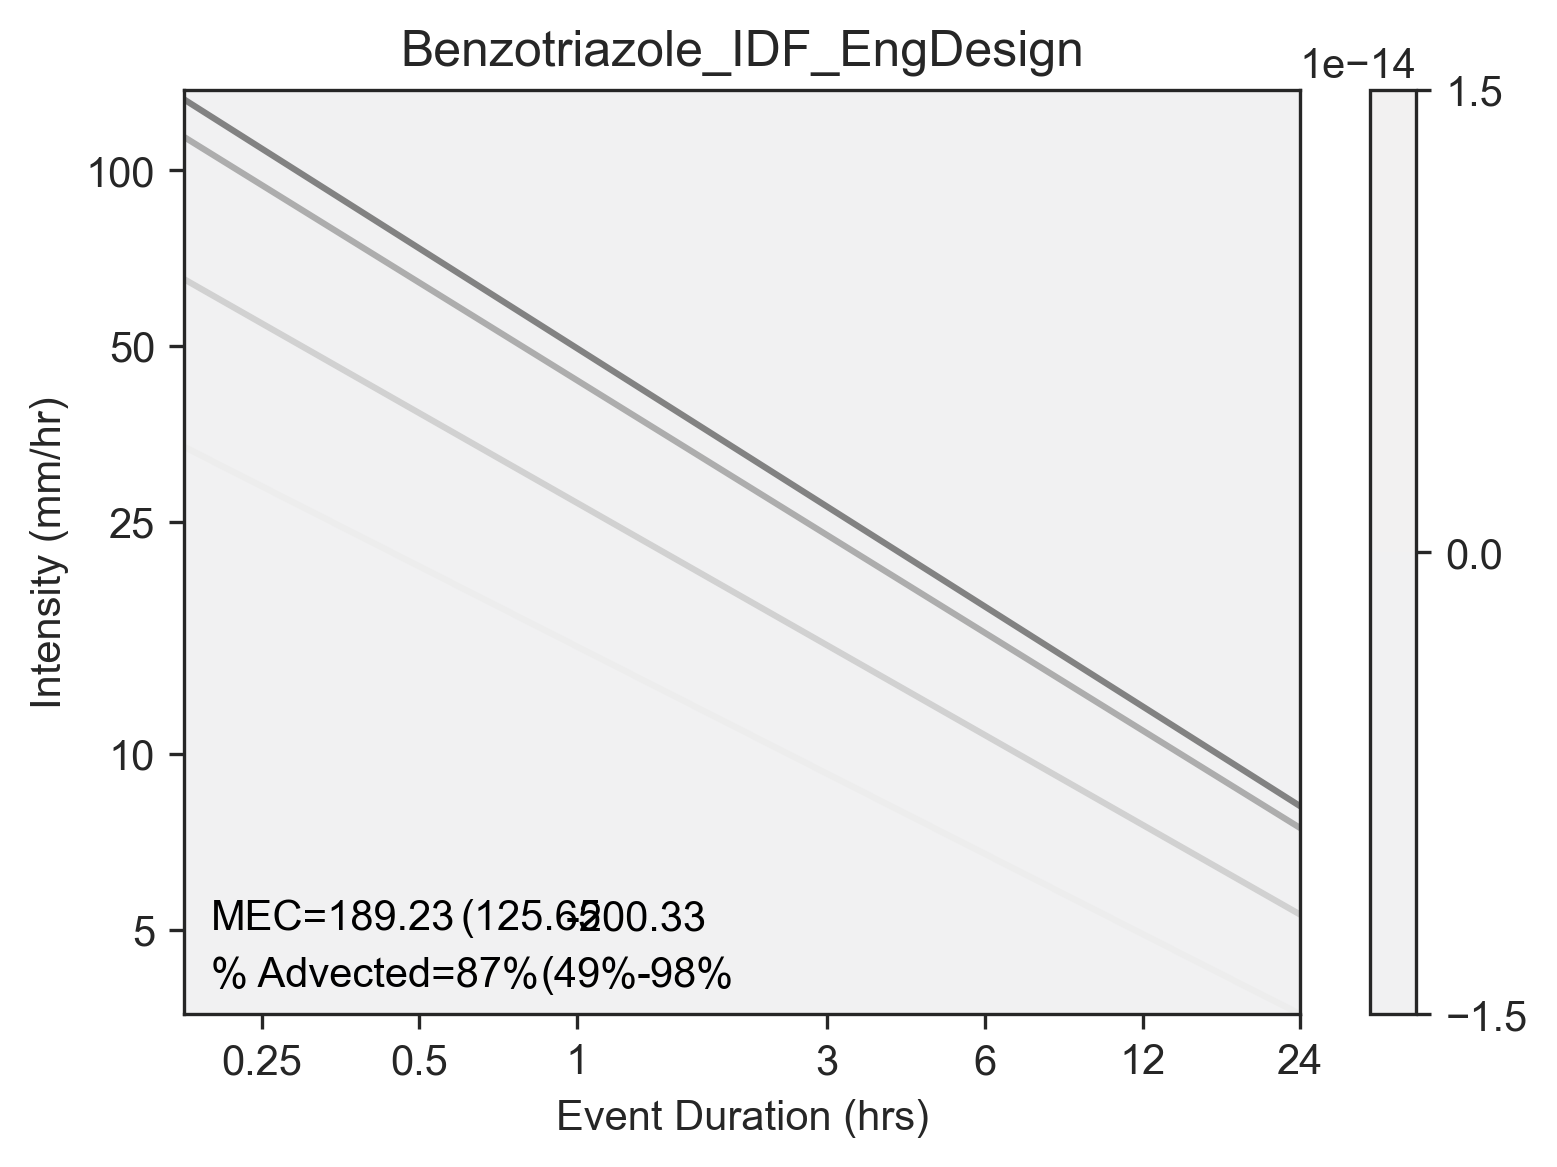

In [37]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set_style('ticks')
import matplotlib.pyplot as plt
#This is the name of the python module containing the Bioretention Blues submodel.
from BioretentionBlues import BCBlues
import os
import itertools
import pdb
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/Pine8th/EngDesign_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/Pine8th/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/Pine8th/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_EngDesign.pkl'
#defname = 'IDF_.pkl'
defdf = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 
                         'Asys':False, 'Hp':False, 'hpipe':False, 'amend':False}
#combos = ((0,0,0,0,0,0,0,0,0),(1,0,0,0,0,0,0,0),(0,1,0,0,0,0,0,0),(0,0,1,0,0,0,0,0),(0,0,0,1,0,0,0,0),(0,0,0,0,1,0,0,0),
#          (0,0,0,0,0,1,0,0),(0,0,0,0,0,0,1,0),(0,0,0,0,0,0,0,1))
#combos = ((1,0,0,0,0,0,0),)#(0,1,0,0,0,0),(0,0,1,0,0,0),(0,0,0,1,0,0),(0,0,0,0,1,0),(0,0,0,0,0,1),
#          (1,1,0,0,1,1),(1,1,0,0,0,1))
combos = ((0,0,0,0,0,0,0,0,0),)
#for scenario in scenarios:
#combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]
#combos = ((0,0,0,0,0,0,1),(0,0,1,0,0,0,0))
#combos =((0,1,0,0,0,0,0),)
for combo in combos:
    #pdb.set_trace()
    scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 
                         'Asys':False, 'Hp':False, 'hpipe':False, 'amend':False}
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    testname = 'IDF_EngDesign'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_EngDesign_lowKn'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdf = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    #Define the x and y axes
    #pdb.set_trace()
    xticks = [0.25,0.5,1,3, 6,12,24]
    xticks = [np.log10(xticks),xticks]
    yticks = [5,10,25,50,100]
    yticks = [np.log10(yticks),yticks]
    #Define the variables to plot
    for compound in pltdf.index.unique(): #
        pltdata = pltdf.loc[compound,:].copy(deep=True)
        defdata = defdf.loc[compound,:].copy(deep=True)
        pltvars=['pct_stormsewer','LogD','LogI']
        #pltvars=['pct_advected','LogD','LogI']
        pltvars_delta = pltvars.copy()
        delname = pltvars[0] +'_delta'
        pltvars_delta[0] = delname
        pltdata.loc[:,delname] = defdata.loc[:,pltvars[0]] - pltdata.loc[:,pltvars[0]]
        #pdb.set_trace()
        #pltvars=['RQ_av','LogD','LogI']
        #Determine the average risk quotients, sum as a % of the base-case, av as actual value
        bcRQsum = defdata.RQ_sum.sum()
        RQs = [pltdata.MEC_ngl.mean(),pltdata.MEC_ngl.min(),pltdata.MEC_ngl.max(),
               pltdata.pct_advected.mean(),pltdata.pct_advected.min(),pltdata.pct_advected.max()]
        #pdb.set_trace()
        #Define other parameters
        #Limit of interpolation - values outside of these limits will be set to these. Use "none" for no limits
        hilim = np.round(2*max(pltdata.loc[:,delname]),decimals=2)
        lolim = np.round(2*min(pltdata.loc[:,delname]),decimals=2)
        interplims = [lolim,hilim]
        #interplims = [0.,3.5]
        vlims = [-0.5,0.5]
        #vlims = [lolim,hilim]#[0.15,3.5]#
        #pdb.set_trace()
        #define the colormap - default is brown-blue
        #cmap = None
        #if lolim<0:
        #    cmap = sns.diverging_palette(250, 30, l=40,s=80,center="light", as_cmap=True)
        #else: 
        #    cmap = sns.light_palette('#8f4e27', as_cmap=True)
        cmap = sns.diverging_palette(250, 30, l=40,s=80,center="light", as_cmap=True)
            #cmap = sns.light_palette("seagreen", as_cmap=True)
        #cmap = sns.cubehelix_palette(start=.75, rot=-.5,light=0.85, as_cmap=True)
        #cmap = sns.cubehelix_palette(n_colors = 7,start=1.40, rot=-0.9,gamma = 0.3, hue = 0.9, dark=0.1, light=.95,as_cmap=True,reverse=True)
        bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) 
        fig,ax = bc.plot_idfs(pltdata,pltvars=pltvars_delta,cmap=cmap,vlims=vlims,interplims=interplims,
                              xticks=xticks,yticks=yticks,figsize=(6,4))
        ax.set_xlabel('Event Duration (hrs)')
        ax.set_ylabel('Intensity (mm/hr)')
        #figname = 'IDF_delta_'+str(scenario)
        figname = compound+'_IDF_EngDesign'+'_'.join(filtered)
        ax.set_title(figname)
        #Annotate the risk quotients
        ax.annotate('MEC='+f'{RQs[0]:.2f}',xy= (np.log10(0.2),np.log10(5)),color = 'k')
        ax.annotate('('+f'{RQs[1]:.2f}',xy= (np.log10(0.60),np.log10(5)),color = 'k')
        ax.annotate('-'+f'{RQs[2]:.2f}',xy= (np.log10(0.95),np.log10(5)),color = 'k')
        ax.annotate('% Advected='+f'{RQs[3]:.0%}',xy= (np.log10(0.2),np.log10(4)),color = 'k')   
        ax.annotate('('+f'{RQs[4]:.0%}',xy= (np.log10(0.85),np.log10(4)),color = 'k')   
        ax.annotate('-'+f'{RQs[5]:.0%}',xy= (np.log10(1.3),np.log10(4)),color = 'k')   
        figpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
        #
        fig.savefig(figpath+figname+'.pdf',format='pdf')
    #fig.savefig()

In [58]:
pltdata.loc[:,'Qbal'] = (pltdata.pct_Qover + pltdata.pct_Qexf\
        + pltdata.pct_Qet + pltdata.pct_Qdrain)
pltdata.loc[:,['Duration','Frequency','Qbal']]
#testname

C:\Users\trodge01\AppData\Local\Temp\ipykernel_24196\2736444325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pltdata.loc[:,'Qbal'] = (pltdata.pct_Qover + pltdata.pct_Qexf\


Duration Frequency      Qbal
Compound                                  
Benzotriazole    10min       2yr  0.651293
Benzotriazole    10min      10yr  0.315945
Benzotriazole    10min     100yr  0.577775
Benzotriazole    10min     200yr  0.635855
Benzotriazole    30min       2yr  0.339952
Benzotriazole    30min      10yr  0.462656
Benzotriazole    30min     100yr  0.672116
Benzotriazole    30min     200yr  0.718142
Benzotriazole      1hr       2yr  0.275673
Benzotriazole      1hr      10yr  0.610430
Benzotriazole      1hr     100yr  0.769266
Benzotriazole      1hr     200yr  0.799358
Benzotriazole      2hr       2yr  0.320101
Benzotriazole      2hr      10yr  0.673456
Benzotriazole      2hr     100yr  0.812888
Benzotriazole      2hr     200yr  0.852563
Benzotriazole      6hr       2yr  0.251865
Benzotriazole      6hr      10yr  0.851102
Benzotriazole      6hr     100yr  0.901214
Benzotriazole      6hr     200yr  0.911204
Benzotriazole     12hr       2yr  0.305203
Benzotriazole     12hr      10yr  0.363169
Benzotriazole     12hr     100yr  0.442660
Benzotriazole     12hr     200yr  0.468618
Benzotriazole     24hr       2yr  0.432169
Benzotriazole     24hr      10yr  0.450278
Benzotriazole     24hr     100yr  0.481993
Benzotriazole     24hr     200yr  0.492761

In [22]:
#Find best scenarios - low exfiltration
import os
import itertools
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/Pine8th/EngDesign_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/Pine8th/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/Pine8th/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_EngDesign.pkl'
#defname = 'IDF_EngDesign_lowkn.pkl'
defdf = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 
                         'Asys':False, 'Hp':False, 'hpipe':False, 'amend':False}
#combos = ((1,0,0,0,0,0,0,0),(0,1,0,0,0,0,0,0),(0,0,1,0,0,0,0,0),(0,0,0,1,0,0,0,0),(0,0,0,0,1,0,0,0),
#          (0,0,0,0,0,1,0,0),(0,0,0,0,0,0,1,0),(0,0,0,0,0,0,0,1))
#for scenario in scenarios:
combos = list(itertools.product([0,1],repeat=8))
#combos = ((0,0,0,0,0,0,0,0,0),(1,0,0,0,0,0,0,0),(0,1,0,0,0,0,0,0),(0,0,1,0,0,0,0,0),(0,0,0,1,0,0,0,0),(0,0,0,0,1,0,0,0),
#          (0,0,0,0,0,1,0,0),(0,0,0,0,0,0,1,0),(0,0,0,0,0,0,0,1))
#combos = ((1,0,0,0,0,0,0,0),)
#combos = combos[:38]
scenario_list = pd.DataFrame(columns=['rank','rank_std'])
for combo in combos:
    #pdb.set_trace()

    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    #testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    testname = 'IDF_EngDesign'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_EngDesign_lowKn'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdf = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    for compound in pltdf.index.unique():
        pltdata = pltdf.loc[compound,:]
        defdata = defdf.loc[compound,:]
        bcRQsum = defdata.RQ_sum.sum()
        #indname = compound+testname[4:-4] 
        indname = testname[4:-4] 
        scenario_list.loc[indname,compound+'_RQ_sum'] = pltdata.RQ_sum.sum()/bcRQsum
        scenario_list.loc[indname,compound+'_RQ_av'] =pltdata.RQ_av.mean()
        scenario_list.loc[indname,compound+'_pct_advected'] =pltdata.pct_advected.mean()
        scenario_list.loc[indname,compound+'_MEC_ngl'] =pltdata.MEC_ngl.mean()
        scenario_list.loc[indname,compound+'_pct_stormsewer'] =pltdata.pct_stormsewer.mean()
        scenario_list.loc[indname,compound+'_pct_Qover'] =pltdata.pct_Qover.mean()
        scenario_list.loc[indname,compound+'_pct_Qexf'] =pltdata.pct_Qexf.mean()
        scenario_list.loc[indname,compound+'_pct_Qet'] =pltdata.pct_Qet.mean()
        scenario_list.loc[indname,compound+'_pct_Qdrain'] =pltdata.pct_Qdrain.mean()
        scenario_list.loc[indname,compound+'_draintime'] =pltdata.draintime.mean()
        scenario_list.loc[indname,compound+'_Qbal'] = (pltdata.pct_Qover + pltdata.pct_Qexf\
        + pltdata.pct_Qet + pltdata.pct_Qdrain).mean()
        #scenario_list.loc[indname,'compound'] =compound
#scenario_list.to_csv(figpath+'ind_designs.csv')        
#scenario_list[scenario_list.compound=='BaP'].sort_values('RQ_sum',ascending=True)#[0:25]
#rankby = 'RQ_sum'
#collist = []
#for compound in pltdf.index.unique():
#    collist.append(compound+rankby)
#scenario_list.loc[:,'rank'] = scenario_list.loc[:,collist].rank().mean(axis=1)
    
#scenario_list.sort_values('rank',ascending=True)#[0:25]
#scenario_list.to_csv(fpath+'ind_designs_lowKn.csv')  

In [23]:
rankby = 'pct_advected' # 'pct_advected' #'pct_advected' #
collist = []
for compound in pltdf.index.unique():
    collist.append(compound+'_'+rankby)
scenario_list.loc[:,collist]#.rank()

6PPDQ_pct_advected  PFOA_pct_advected  Phe_pct_advected  \
EngDesign                       0.391683           0.940143          0.283431   
EngDesignamend                  0.291573           0.538476          0.272491   
EngDesignhpipe                  0.381260           0.847280          0.282821   
EngDesignhpipe_amend            0.290423           0.511910          0.272407   
EngDesignHp                     0.309511           0.940909          0.179958   
EngDesignHp_amend               0.189310           0.482789          0.166246   
EngDesignfvalve                 0.399734           0.940157          0.284156   

                      BaP_pct_advected  Benzotriazole_pct_advected  \
EngDesign                     0.270247                    0.872983   
EngDesignamend                0.270246                    0.272798   
EngDesignhpipe                0.270240                    0.797143   
EngDesignhpipe_amend          0.270239                    0.272736   
EngDesignHp                   0.162617                    0.866659   
EngDesignHp_amend             0.162616                    0.165919   
EngDesignfvalve               0.270820                    0.876063   

                      TCEP_pct_advected  
EngDesign                      0.783544  
EngDesignamend                 0.307955  
EngDesignhpipe                 0.722842  
EngDesignhpipe_amend           0.305103  
EngDesignHp                    0.764503  
EngDesignHp_amend              0.209174  
EngDesignfvalve                0.793087

In [61]:
rankby = 'pct_advected' #'pct_stormsewer'
fpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
collist = []
for compound in pltdf.index.unique():
    collist.append(compound+'_'+rankby)
scenario_list.loc[:,'rank'] = scenario_list.loc[:,collist].rank().mean(axis=1)
scenario_list.loc[:,'rank_std'] = scenario_list.loc[:,collist].rank().std(axis=1)


scenario_list.to_csv(fpath+'ind_designs.csv')     
ranked = scenario_list.sort_values('rank',ascending=True)[0:25]
#ranked.loc['EngDesign',:] = scenario_list.loc['EngDesign',:]
#ranked.to_csv(fpath+'ind_designs.csv')     
ranked
scenario_list.loc[:,:]#.rank()

C:\Users\trodge01\AppData\Local\Temp\ipykernel_24196\1790259120.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  scenario_list.loc[:,'rank'] = scenario_list.loc[:,collist].rank().mean(axis=1)
C:\Users\trodge01\AppData\Local\Temp\ipykernel_24196\1790259120.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  scenario_list.loc[:,'rank_std'] = scenario_list.loc[:,collist].rank().std(axis=1)


rank  rank_std  6PPDQ_RQ_sum  6PPDQ_RQ_av  \
EngDesign_lowKnfvalve   1.0       0.0      1.091638     0.170553   

                       6PPDQ_pct_advected  6PPDQ_MEC_ngl  \
EngDesign_lowKnfvalve            0.383868     170.552958   

                       6PPDQ_pct_stormsewer  6PPDQ_pct_Qover  6PPDQ_pct_Qexf  \
EngDesign_lowKnfvalve              0.360488         0.360038        0.166029   

                       6PPDQ_pct_Qet  ...  Benzotriazole_RQ_sum  \
EngDesign_lowKnfvalve       0.039638  ...              0.257382   

                       Benzotriazole_RQ_av  Benzotriazole_pct_advected  \
EngDesign_lowKnfvalve             0.171178                     0.49737   

                       Benzotriazole_MEC_ngl  Benzotriazole_pct_stormsewer  \
EngDesign_lowKnfvalve              171.17827                      0.361547   

                       Benzotriazole_pct_Qover  Benzotriazole_pct_Qexf  \
EngDesign_lowKnfvalve                 0.360038                0.166029   

                       Benzotriazole_pct_Qet  Benzotriazole_pct_Qdrain  \
EngDesign_lowKnfvalve               0.039638                       0.0   

                       Benzotriazole_Qbal  
EngDesign_lowKnfvalve            0.565704  

[1 rows x 52 columns]

In [12]:
#Lets build scatter plots to show how the design scenarios perform across compounds
scenario_list
#pltdata = pd.DataFrame(index=chemsumm.index)
#pltdata.loc[:,'LogDoc'] = [-1.50,1.846,3.14,4.15,6.74]
#collist = []
#for compound in pltdata.index.unique():
#    collist.append(compound+'_'+rankby)
#ranked.loc[:,collist]/ranked.loc['EngDesign',collist]

rank rank_std  6PPDQ_RQ_sum  6PPDQ_RQ_av  \
EngDesign_lowKnfvalve  NaN      NaN      9.347281      0.14771   

                       6PPDQ_pct_advected  6PPDQ_MEC_ngl  \
EngDesign_lowKnfvalve            0.578168      147.70982   

                       6PPDQ_pct_stormsewer  6PPDQ_pct_Qover  6PPDQ_pct_Qexf  \
EngDesign_lowKnfvalve              0.578168         0.579569        0.326967   

                       6PPDQ_pct_Qet  ...  TCEP_RQ_av  TCEP_pct_advected  \
EngDesign_lowKnfvalve       0.092616  ...    0.148627           0.581612   

                       TCEP_MEC_ngl  TCEP_pct_stormsewer  TCEP_pct_Qover  \
EngDesign_lowKnfvalve    148.626933             0.581612        0.579569   

                       TCEP_pct_Qexf  TCEP_pct_Qet  TCEP_pct_Qdrain  \
EngDesign_lowKnfvalve       0.326967      0.092616              0.0   

                       TCEP_draintime  TCEP_Qbal  
EngDesign_lowKnfvalve           19.15   0.999152  

[1 rows x 68 columns]

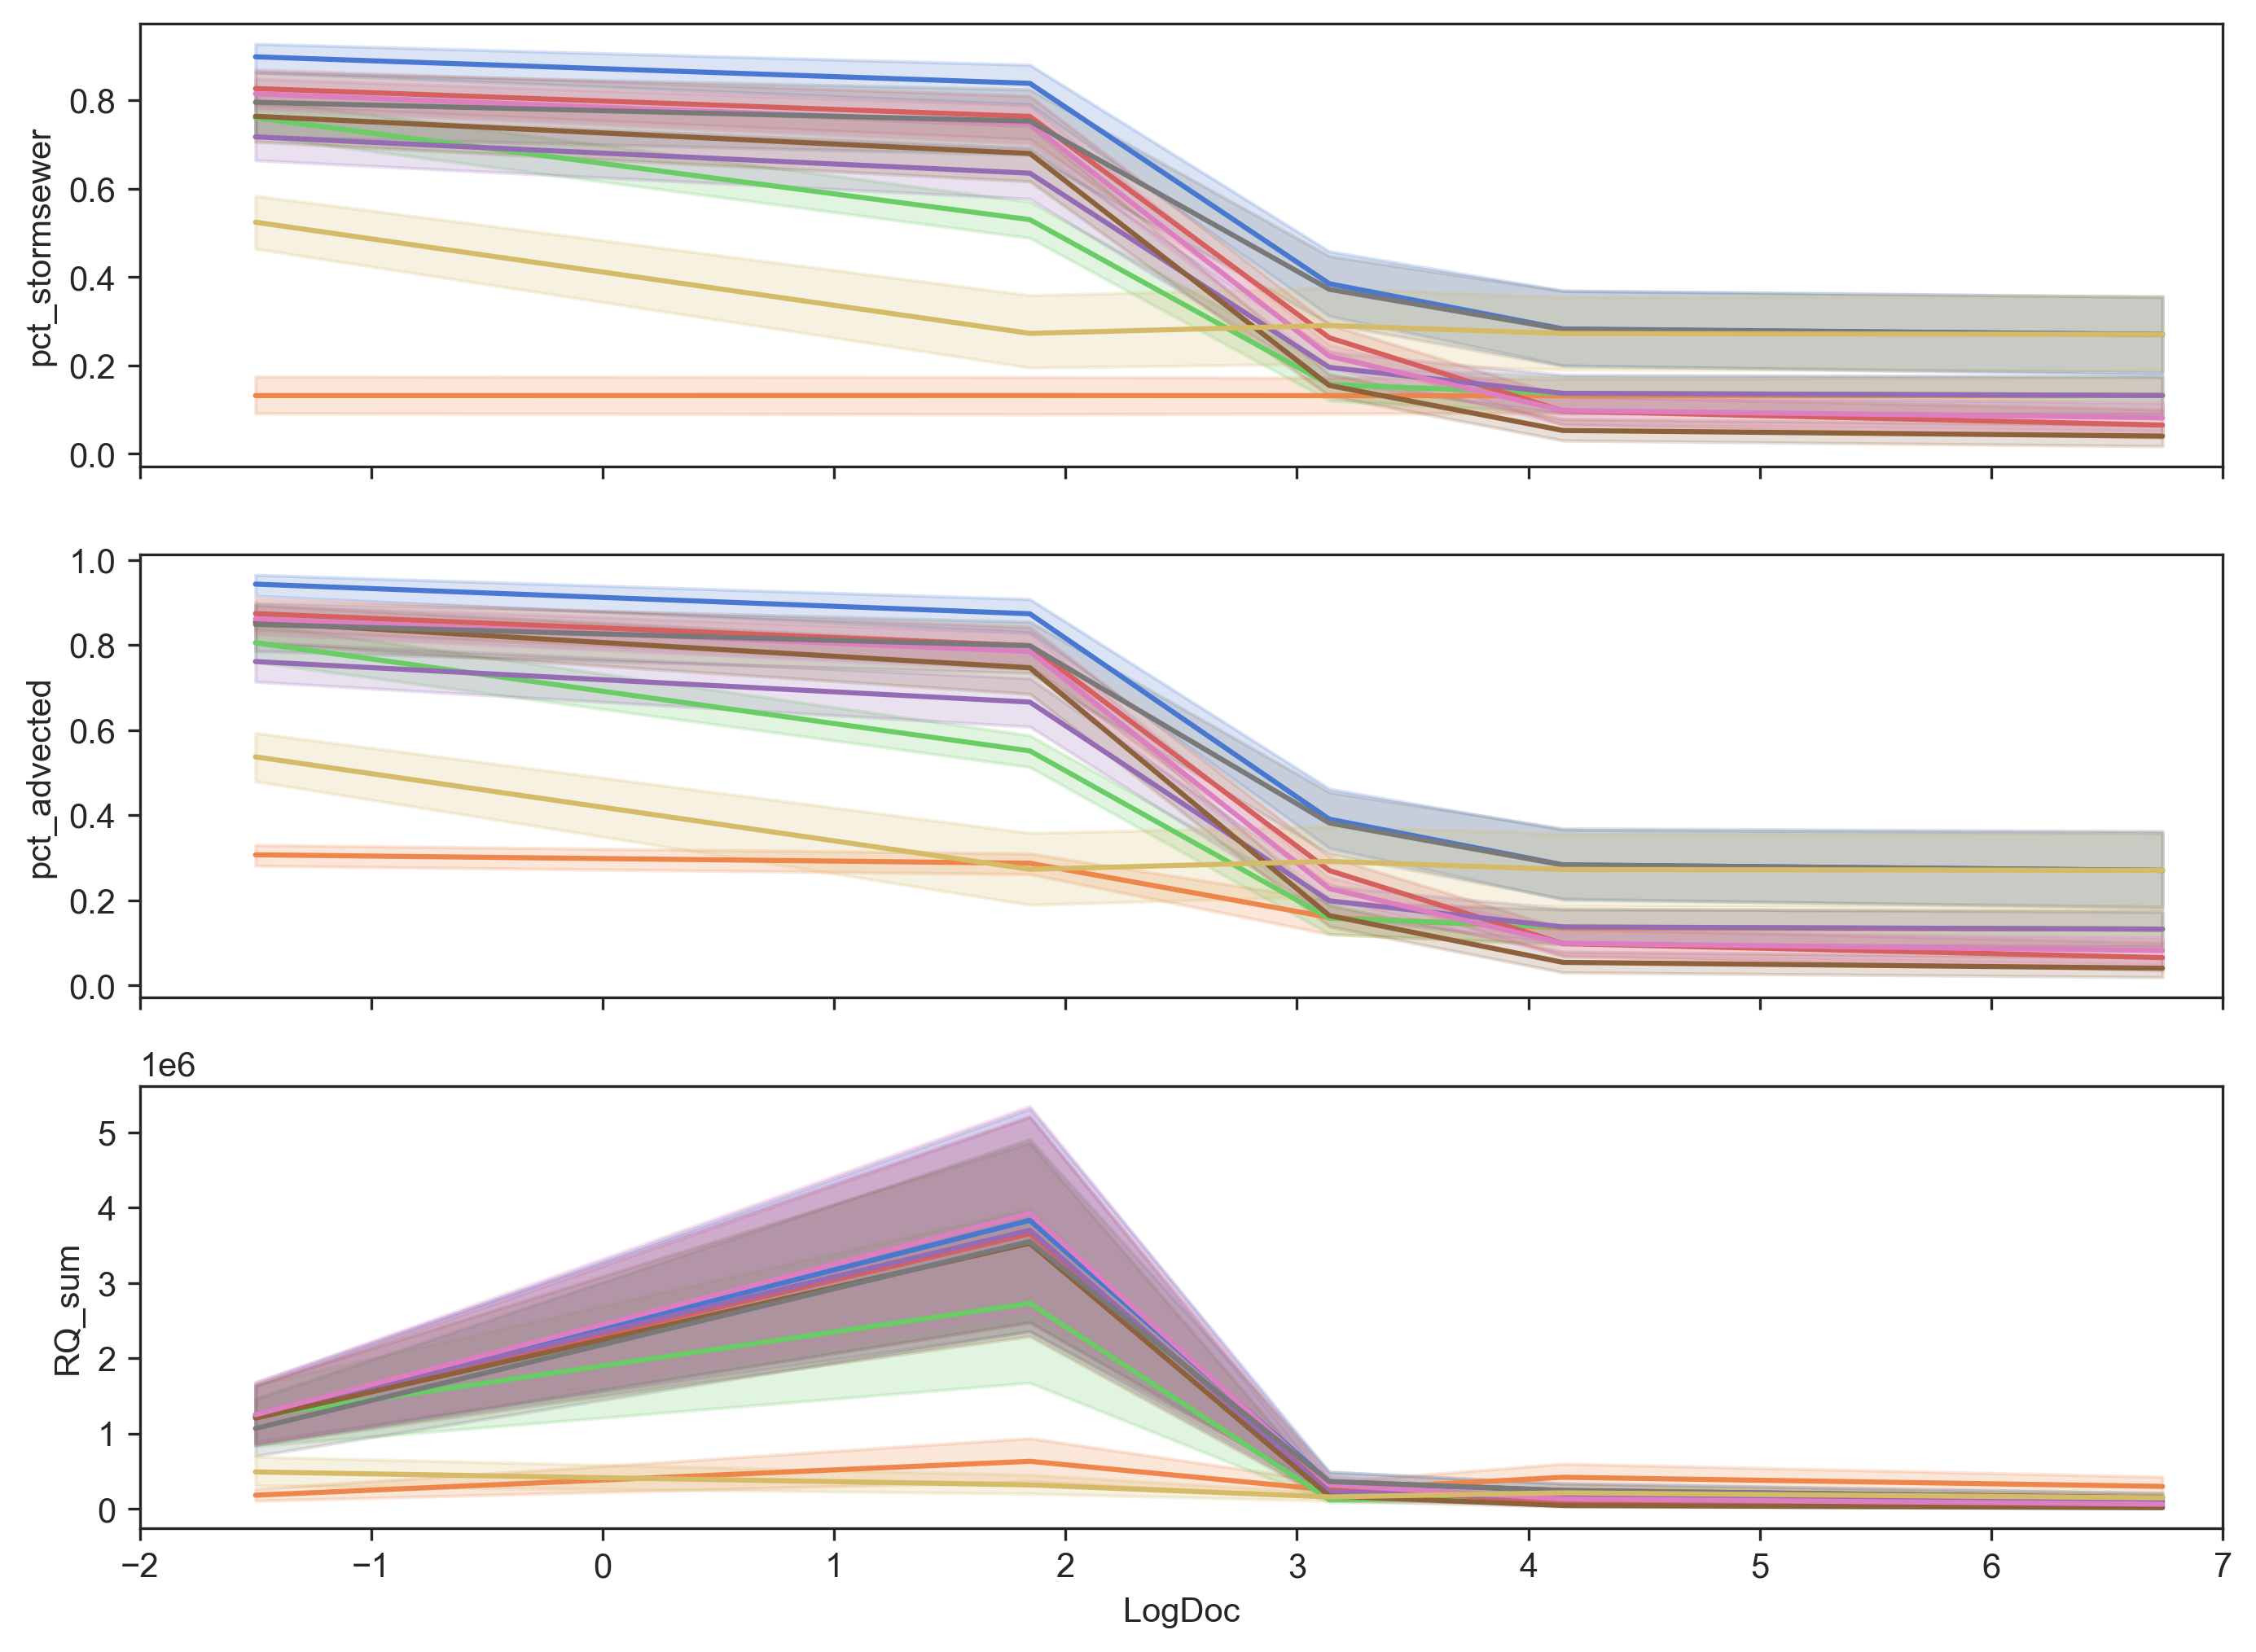

In [12]:
#scenario_list.loc[:,collist].rank()
#scenario_list.loc[:,'BaP_RQ_sum':]
#(ranked.loc[:,collist]/ranked.loc['EngDesign',collist])
#ranked.loc[:,collist]
LogDoc = {'PFOA':-1.50,'Benzotriazole':1.846,'6PPDQ':3.14,'Phe':4.15,'BaP':6.74}
sns.set_style('ticks')
palette = 'muted'
fig,ax = plt.subplots(3,1,figsize=(11,8),dpi=300,sharex=True)
LogDoc = {'PFOA':-1.50,'Benzotriazole':1.846,'6PPDQ':3.14,'Phe':4.15,'BaP':6.74}
bigdf.loc[:,'LogDoc'] = bigdf.index.map(LogDoc)
sns.lineplot(data=bigdf,x='LogDoc',y='pct_stormsewer',markers=True,ax = ax[0],hue='Scenario',palette=palette)
sns.lineplot(data=bigdf,x='LogDoc',y='pct_advected',markers=True,ax = ax[1],hue='Scenario',palette=palette)
sns.lineplot(data=bigdf,x='LogDoc',y='RQ_sum',markers=True,ax = ax[2],hue='Scenario',palette=palette)
ax[0].set_xlim([-2,7]);

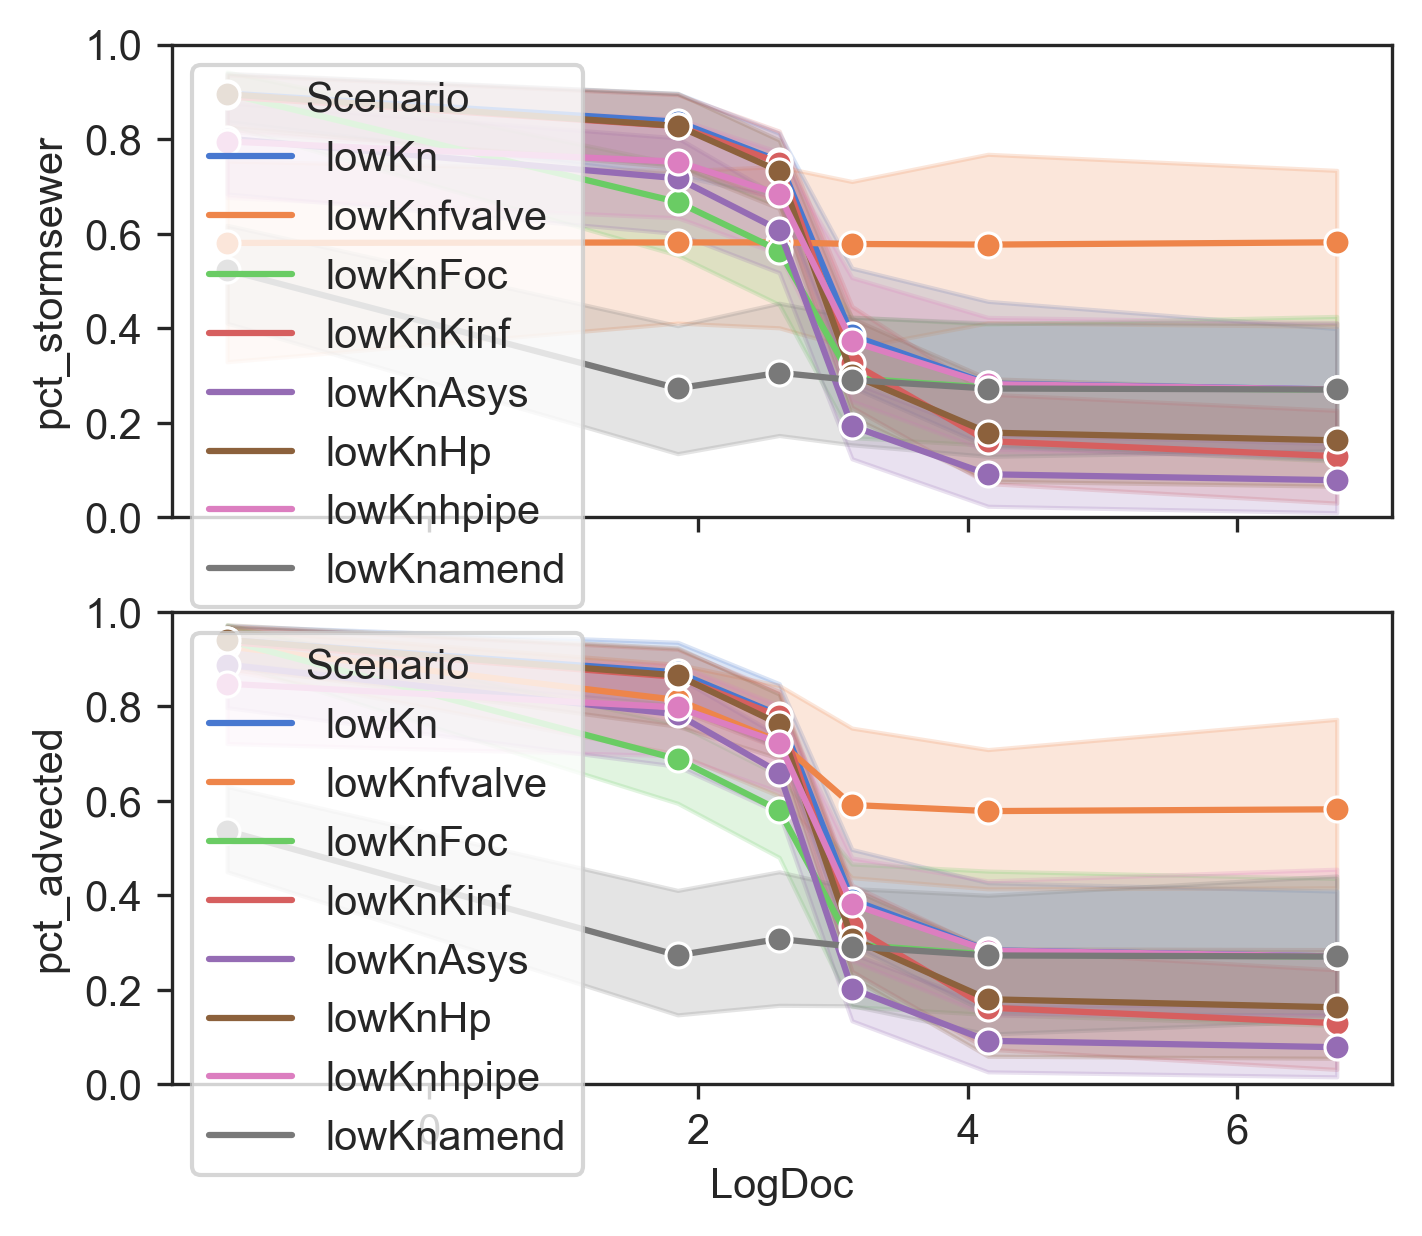

In [36]:
#defdf[defdf.index=='Phe']
#Find best scenarios - low exfiltration
import os
import itertools
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/Pine8th/EngDesign_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/Pine8th/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/Pine8th/timeseries_IDFstorms.xlsx')
#Load data
#defname = 'IDF_EngDesign.pkl'
defname = 'IDF_EngDesign_lowKn.pkl'
defdf = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 
                         'Asys':False, 'Hp':False, 'hpipe':False, 'amend':False}
combos = ((0,0,0,0,0,0,0,0),(1,0,0,0,0,0,0,0),(0,1,0,0,0,0,0,0),(0,0,1,0,0,0,0,0),(0,0,0,1,0,0,0,0),(0,0,0,0,1,0,0,0),
          (0,0,0,0,0,1,0,0),(0,0,0,0,0,0,1,0),(0,0,0,0,0,0,0,1))
#for scenario in scenarios:
#combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]
scenario_list = pd.DataFrame(columns=['rank','rank_std'])
#fig,ax = plt.subplots(3,1,figsize=(14,8),dpi=300,sharey=True)
first = True
for combo in combos:
    #pdb.set_trace()

    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    #testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_EngDesign'+'_'.join(filtered)+'.pkl'
    testname = 'IDF_EngDesign_lowKn'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdf = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    if testname == 'IDF_EngDesign_lowKn'+'_'.join(filtered)+'.pkl':
        pltdf.loc[:,'Scenario'] = testname[14:-4]
    else:
        pltdf.loc[:,'Scenario'] = testname[13:-4]
    pltdf.loc[:,'RRQ'] = pltdf.RQ_sum/defdf.RQ_sum
    if first == True:
        bigdf = pltdf.copy(deep=True)
        first = False
    else:
        bigdf = bigdf.append(pltdf)
    #fig,ax = plt.subplots(3,1,figsize=(14,8),dpi=300,sharey=True)
    #LogDoc = {'PFOA':-1.50,'Benzotriazole':1.846,'6PPDQ':3.14,'Phe':4.15,'BaP':6.74}
    #pltdf.loc[:,'LogDoc'] = pltdf.index.map(LogDoc)
    #sns.lineplot(data=pltdf,x='LogDoc',y='pct_stormsewer',markers=True)
#pltdf.loc[:,'Scenario']
bigdf.loc[bigdf.loc[:,'Scenario'] == '','Scenario'] = 'Base-Case'

sns.set_style('ticks')
palette = 'muted'
fig,ax = plt.subplots(2,1,figsize=(5.25,4.5),dpi=300,sharex=True,sharey=True)
LogDoc = {'PFOA':-1.50,'Benzotriazole':1.846,'TCEP':2.60,'6PPDQ':3.14,'Phe':4.15,'BaP':6.74}
bigdf.loc[:,'LogDoc'] = bigdf.index.map(LogDoc)
pltscenarios = 'all' #['Base-Case','fvalve','Asys','hpipe']# 
if pltscenarios != 'all':
    bigdf = bigdf.loc[bigdf.Scenario.isin(pltscenarios)]
legend = 'full'# False#
sns.lineplot(data=bigdf,x='LogDoc',y='pct_stormsewer',ax = ax[0],hue='Scenario',palette=palette,legend = legend,marker='o',errorbar=('ci',100))
sns.lineplot(data=bigdf,x='LogDoc',y='pct_advected',ax = ax[1],hue='Scenario',palette=palette,legend = legend,marker='o',errorbar=('ci',100))
#sns.lineplot(data=bigdf,x='LogDoc',y='RRQ',ax = ax[2],hue='Scenario',palette=palette,legend = legend,marker='o')
ax[0].set_ylim([0,1]);
fpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
#fig.savefig(fpath+'DesignvsKoc_base.pdf', format='pdf',bbox_inches= 'tight')   
#fig.savefig(fpath+'DesignvsKoc_lowKn.pdf', format='pdf',bbox_inches= 'tight')   

In [35]:
bigdf.pct_Qover.mean()

0.27081209570687936

In [34]:
#pltdf.loc[:,delname] = defdf.loc[:,pltvars[0]] - pltdf.loc[:,pltvars[0]]
#defdf.loc[defdf.index=='PFOA','pct_advected':]-pltdf.loc[pltdf.index=='PFOA','pct_advected':]#.mean(axis=0)-defdf[defdf.index=='PFOA'].mean(axis=0)#/defdf[defdf.index=='Phe']#.pct_stormsewer.mean()
#pltdf.loc[pltdf.index=='PFOA','pct_advected':]
#defdf[defdf.Duration=='10min']#.pct_sorbed.groupby(defdf.index).mean()
#pltscenarios = ['Base-Case','fvalve','hpipe']#['Base-Case']#
pltscenarios = ['lowKn','lowKnfvalve','lowKnhpipe']
xx = bigdf.loc[bigdf.Scenario.isin(pltscenarios)]
#xx[xx.pct_advected == xx.loc[xx.index=='PFOA','pct_advected'].max()]
cols = ['Duration','Frequency','pct_advected','pct_sorbed','pct_Qover','pct_Qexf','pct_Qet','draintime','Scenario']
#xx.loc[xx.index=='PFOA',cols]
xx.loc[(xx.index=='BaP')&(xx.Duration=='24hr'),cols]
#bigdf
#bigdf
#defdata#[defdata.Compound=='PFOA']

Duration Frequency  pct_advected  pct_sorbed  pct_Qover  pct_Qexf  \
Compound                                                                     
BaP          24hr       2yr      0.011677    0.986944   0.011287  0.051012   
BaP          24hr      10yr      0.078300    0.920424   0.077163  0.035425   
BaP          24hr     100yr      0.152920    0.845923   0.151649  0.025632   
BaP          24hr     200yr      0.175348    0.823533   0.174132  0.023582   
BaP          24hr       2yr      0.752523    0.246411   0.749724  0.174290   
BaP          24hr      10yr      0.832105    0.167164   0.830277  0.118358   
BaP          24hr     100yr      0.880616    0.118861   0.879424  0.084169   
BaP          24hr     200yr      0.890561    0.108959   0.889499  0.077137   
BaP          24hr       2yr      0.011677    0.986945   0.011287  0.066705   
BaP          24hr      10yr      0.078300    0.920425   0.077163  0.045801   
BaP          24hr     100yr      0.152920    0.845924   0.151649  0.032873   
BaP          24hr     200yr      0.175348    0.823533   0.174132  0.030201   

           pct_Qet  draintime     Scenario  
Compound                                    
BaP       0.049379  16.800000        lowKn  
BaP       0.033628  18.750000        lowKn  
BaP       0.023995  17.133333        lowKn  
BaP       0.022011  18.833333        lowKn  
BaP       0.075750  29.800000  lowKnfvalve  
BaP       0.051191  29.916667  lowKnfvalve  
BaP       0.036290  29.983333  lowKnfvalve  
BaP       0.033241  30.016667  lowKnfvalve  
BaP       0.049316  16.800000   lowKnhpipe  
BaP       0.033585  18.750000   lowKnhpipe  
BaP       0.023969  17.133333   lowKnhpipe  
BaP       0.021996  18.833333   lowKnhpipe

In [117]:
#xx.loc[pd.np.where(xx.index.str.contains('P')),'newcol'] = 1
#xx.loc[pd.np.where(xx.index.str.contains('F')),'Duration']
for ind, val in enumerate(xx.index.unique()):
    xx.loc[xx.index.str.contains(val),'newcol'] = ind

C:\Users\trodge01\AppData\Local\Temp\ipykernel_15204\1973129549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xx.loc[xx.index.str.contains('F'),'newcol'] = 1
